In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

import collections

import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv1D,Conv2D, Flatten
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, Add, Flatten, Dense)
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

from tensorflow.keras.metrics import AUC
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

/home/ubuntu/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# import modules

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, recall_score, f1_score, balanced_accuracy_score, classification_report, roc_curve, precision_score
from PIL import Image
import matplotlib.cm as cm

In [3]:
# Check path
my_path = os.getcwd()
train_dir = '/home/ubuntu/dr-you-ecg-20220420_mount/STEMI_JKL/221028_STEMI/'
My_dir = '/home/ubuntu/dr-you-ecg-20220420_mount/STEMI_JKL/2023_Jan_testset/'

# load dataset
X_train, Y_train = np.load(train_dir+'x_train_1114.npy'), np.load(train_dir+'y_train_1114.npy')
X_test, Y_test = np.load(My_dir+'x_test_0114.npy'), np.load(My_dir+'y_test_0114.npy')
X_pain, Y_pain = np.load(My_dir+'x_pain_0113.npy'), np.load(My_dir+'y_pain_0113.npy')

print('X_train {}, Y_train {}'.format(X_train.shape, Y_train.shape))
print('X_test {}, Y_test {}'.format(X_test.shape, Y_test.shape))
print('X_pain {}, Y_pain {}'.format(X_pain.shape, Y_pain.shape))

X_train (17379, 5000, 8), Y_train (17379,)
X_test (1318, 5000, 8), Y_test (1318,)
X_pain (2765, 5000, 8), Y_pain (2765,)


In [4]:
# Split train and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)
print('X_train {}, Y_train {}\nX_val {}, Y_val {}'.format(X_train.shape , Y_train.shape, X_val.shape, Y_val.shape))

X_train (15641, 5000, 8), Y_train (15641,)
X_val (1738, 5000, 8), Y_val (1738,)


In [5]:
# Transform dataset to categorical (one-hot encoding)
y_train =  tf.keras.utils.to_categorical(Y_train)
y_val =  tf.keras.utils.to_categorical(Y_val)
y_test = tf.keras.utils.to_categorical(Y_test)
y_pain = tf.keras.utils.to_categorical(Y_pain)
print('y_train {}\ny_val {}\ny_test {}\ny_pain {}'.format(y_train.shape, y_val.shape, y_test.shape, y_pain.shape))

y_train (15641, 2)
y_val (1738, 2)
y_test (1318, 2)
y_pain (2765, 2)


In [6]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
pain_dataset = tf.data.Dataset.from_tensor_slices((X_pain, y_pain))

train_dataset = train_dataset.batch(128)
val_dataset = val_dataset.batch(128)
test_dataset = test_dataset.batch(128)
pain_dataset = pain_dataset.batch(128)

In [7]:
# Load saved model
mpath = '/home/ubuntu/Kyulee/ECG_2210/'
nets = 5
de_model = [0]*5
for i in [0,1,2,3,4]:
    de_model[i] = keras.models.load_model(mpath+'ami_model/BestModelSaved/221204_1643'+str(i+1)+'_bestmodel.h5')

In [8]:
# deep ensemble model TEST
def test_demodel(de_model, y_test, x_dataset):
    each_proba = []
    for m in de_model:
        proba = m.predict(x_dataset)
        each_proba.append(proba)
    results = np.zeros( (y_test.shape[0],2) )
    for p in each_proba:
        results += p
    de_proba = results / len(de_model)
    return de_proba

In [9]:
# Predict val and test data (Probability)
prob1_train = test_demodel(de_model, y_train, train_dataset)
prob1_val = test_demodel(de_model, y_val, val_dataset)
prob1_test = test_demodel(de_model, y_test, test_dataset)
prob1_pain = test_demodel(de_model, y_pain, pain_dataset)

22/22 [==============================] - 1s 36ms/step


In [10]:
y_train.shape

(15641, 2)

In [11]:
prob1_train.shape

(15641, 2)

In [12]:
threshold = 0.0768
def classify(proba):
    pred = (proba > threshold).astype(np.int64)
    return pred

In [13]:
pred_train = classify(prob1_train)
pred_val = classify(prob1_val)
pred_test = classify(prob1_test)
pred_pain = classify(prob1_pain)

In [14]:
prob1_train[0:5]

array([[9.99994564e-01, 5.45555449e-06],
       [9.99818313e-01, 1.81675585e-04],
       [9.99802804e-01, 1.97182349e-04],
       [9.96226752e-01, 3.77323116e-03],
       [9.99408317e-01, 5.91689676e-04]])

In [15]:
pred_train[0:5]

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]])

In [16]:
# Prediction Performance (Probability)
def pf(true, pred):
    print(classification_report(np.argmax(true, axis=1), np.argmax(pred, axis=1)))

pf(y_train, pred_train)
pf(y_val, pred_val)
pf(y_test, pred_test)
pf(y_pain, pred_pain)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     14182
           1       0.96      0.55      0.70      1459

    accuracy                           0.96     15641
   macro avg       0.96      0.77      0.84     15641
weighted avg       0.96      0.96      0.95     15641

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1581
           1       0.93      0.50      0.65       157

    accuracy                           0.95      1738
   macro avg       0.94      0.75      0.81      1738
weighted avg       0.95      0.95      0.95      1738

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1189
           1       0.95      0.57      0.71       129

    accuracy                           0.96      1318
   macro avg       0.95      0.79      0.85      1318
weighted avg       0.95      0.96      0.95      1318

              preci

In [126]:
# ROC curve
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, recall_score, f1_score, balanced_accuracy_score, classification_report, roc_curve, precision_score
def draw_curve(y_true, y_proba):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(y_true.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(['blue', 'lightseagreen'])
    for i, color in zip(range(y_true.shape[1]), colors):
        if i == 0:
            pass
        else:
            plt.plot(fpr[i], tpr[i], color=color, lw=1.5, linestyle= 'dashdot', label='Training       AUC = {0:0.2f}' ''.format(roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], lw=1.5, color='black', linestyle='dotted')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

label = {'0': 'Not-STEMI', '1':'STEMI'}

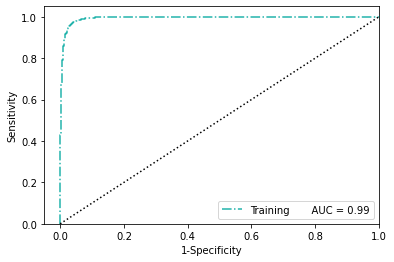

In [127]:
draw_curve(y_train, prob1_train)

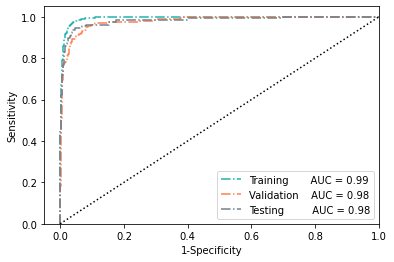

In [147]:
fpr = dict()
tpr = dict()
roc_auc = dict()


fpr[1], tpr[1], _ = roc_curve(y_train[:,1], prob1_train[:, 1])
roc_auc[1] = auc(fpr[1], tpr[1])
plt.plot(fpr[1], tpr[1], color='lightseagreen', lw=1.5, linestyle= 'dashdot', label='Training       AUC = {0:0.2f}' ''.format(roc_auc[1]))

fpr[2], tpr[2], _ = roc_curve(y_val[:,1], prob1_val[:, 1])
roc_auc[2] = auc(fpr[2], tpr[2])
plt.plot(fpr[2], tpr[2], color='coral', lw=1.5, linestyle= 'dashdot', label='Validation    AUC = {0:0.2f}' ''.format(roc_auc[2]))

fpr[3], tpr[3], _ = roc_curve(y_test[:,1], prob1_test[:, 1])
roc_auc[3] = auc(fpr[3], tpr[3])
plt.plot(fpr[3], tpr[3], color='slategrey', lw=1.5, linestyle= 'dashdot', label='Testing         AUC = {0:0.2f}' ''.format(roc_auc[3]))


plt.plot([0, 1], [0, 1], lw=1.5, color='black', linestyle='dotted')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc="lower right")
plt.show()

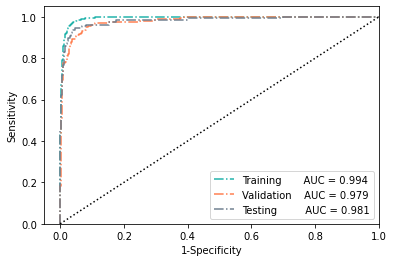

In [157]:
fpr = dict()
tpr = dict()
roc_auc = dict()


fpr[1], tpr[1], _ = roc_curve(y_train[:,1], prob1_train[:, 1])
roc_auc[1] = auc(fpr[1], tpr[1])
plt.plot(fpr[1], tpr[1], color='lightseagreen', lw=1.5, linestyle= 'dashdot', label='Training       AUC = {0:0.3f}' ''.format(roc_auc[1]))

fpr[2], tpr[2], _ = roc_curve(y_val[:,1], prob1_val[:, 1])
roc_auc[2] = auc(fpr[2], tpr[2])
plt.plot(fpr[2], tpr[2], color='coral', lw=1.5, linestyle= 'dashdot', label='Validation    AUC = {0:0.3f}' ''.format(roc_auc[2]))

fpr[3], tpr[3], _ = roc_curve(y_test[:,1], prob1_test[:, 1])
roc_auc[3] = auc(fpr[3], tpr[3])
plt.plot(fpr[3], tpr[3], color='slategrey', lw=1.5, linestyle= 'dashdot', label='Testing         AUC = {0:0.3f}' ''.format(roc_auc[3]))

plt.plot([0, 1], [0, 1], lw=1.5, color='black', linestyle='dotted')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc="lower right")
#plt.gca().set_aspect('equal')  # set aspect ratio to be equal
plt.show()

In [17]:
prob1_train[:, 0]

array([0.99999456, 0.99981831, 0.9998028 , ..., 0.98145407, 0.19161821,
       0.99999828])

- https://seaborn.pydata.org/generated/seaborn.histplot.html?highlight=histplot#seaborn.histplot

<Figure size 432x288 with 0 Axes>

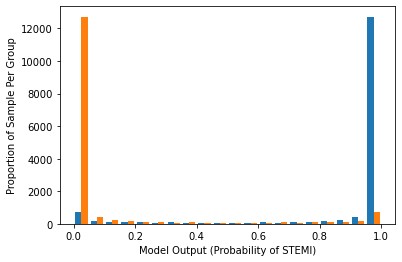

<Figure size 432x288 with 0 Axes>

In [34]:
#import matplotlib.pyplot as plt

plt.hist((prob1_train[:,0], prob1_train[:,1]), bins=20, histtype='bar')
plt.xlabel("Model Output (Probability of STEMI)", size=10)    
plt.ylabel("Proportion of Sample Per Group", size=10)   
plt.figure()

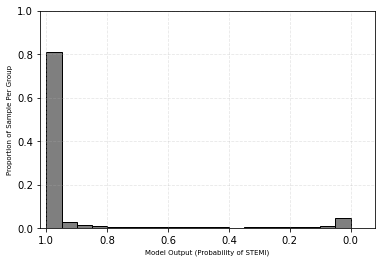

In [66]:
#import matplotlib.pyplot as plt
#from pylab import rcParams
#import seaborn as sns

sns.histplot(data = prob1_train[:,0], bins = 20, color = "Black", legend="Control", stat = "probability", alpha=0.5)   
#sns.histplot(data = prob1_train[:,1], bins = 20, color = "Black", legend="STEMI", stat = "probability", alpha=0.5)   
plt.xlim([1.02,-0.08])  
plt.ylim([0.0, 1.]) 
plt.xlabel("Model Output (Probability of STEMI)", size=7)    
plt.ylabel("Proportion of Sample Per Group", size=7)                
plt.grid(True, alpha=0.3, linestyle="--")   
#plt.rcParams["figure.figsize"] = [1,2]      
#plt.rcParams["figure.dpi"] = 500            
plt.show()

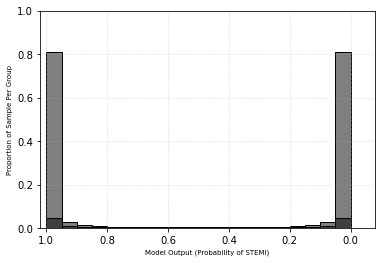

In [57]:
#import matplotlib.pyplot as plt
#from pylab import rcParams
#import seaborn as sns

sns.histplot(data = prob1_train[:,0], bins = 20, color = "Black", legend="Control", stat = "probability", alpha=0.5)   
sns.histplot(data = prob1_train[:,1], bins = 20, color = "Black", legend="STEMI", stat = "probability", alpha=0.5)   
plt.xlim([1.02,-0.08])  
plt.ylim([0.0, 1.]) 
plt.xlabel("Model Output (Probability of STEMI)", size=7)    
plt.ylabel("Proportion of Sample Per Group", size=7)                
plt.grid(True, alpha=0.3, linestyle="--")   
#plt.rcParams["figure.figsize"] = [1,2]      
#plt.rcParams["figure.dpi"] = 500            
plt.show()

In [91]:
df_test = pd.DataFrame({'Probs': prob1_test[:,1], 'Label': y_test[:,1]})
df_test.head()

Probs  Label
0  0.748707    1.0
1  0.684489    1.0
2  0.469005    0.0
3  0.917230    1.0
4  0.986734    1.0

In [92]:
df_test.loc[df_test['Label']==0, 'Label'] = 'Control'
df_test.loc[df_test['Label']==1, 'Label'] = 'STEMI'

In [93]:
df_test.head()

Probs    Label
0  0.748707    STEMI
1  0.684489    STEMI
2  0.469005  Control
3  0.917230    STEMI
4  0.986734    STEMI

In [94]:
stemi = np.array(df_test[df_test['Label']=='STEMI']['Probs'])
control = np.array(df_test[df_test['Label']=='Control']['Probs'])

In [95]:
print(len(stemi), len(control))

129 1189


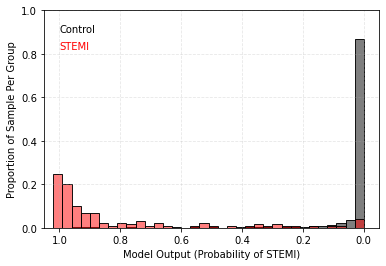

In [139]:
sns.histplot(data = control, binrange=(0,1), bins = 10, binwidth = 0.03,  color = "Black", legend="Control", stat = "probability", alpha=0.5, multiple='dodge')   
sns.histplot(data = stemi, binrange=(0,1), bins = 10, binwidth = 0.03, color = "Red", legend="STEMI", stat = "probability", alpha=0.5, multiple='dodge')   
plt.xlim([1.05,-0.05])  
plt.ylim([0.0, 1.]) 
plt.xlabel("Model Output (Probability of STEMI)", size=10)    
plt.ylabel("Proportion of Sample Per Group", size=10)       
plt.grid(True, alpha=0.3, linestyle="--")   
#plt.rcParams["figure.figsize"] = [1,2]      
#plt.rcParams["figure.dpi"] = 500      
plt.text(1, 0.9, "Control", color="Black", fontsize=10)
plt.text(1, 0.82, "STEMI", color="Red", fontsize=10)

plt.show()

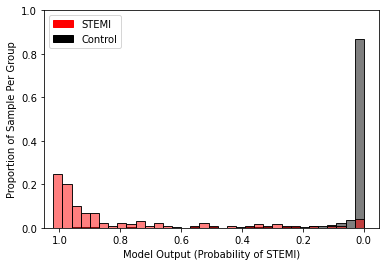

In [150]:
import matplotlib.patches as mpatches

# create color patches for the labels
control_patch = mpatches.Patch(color='black', label='Control')
stemi_patch = mpatches.Patch(color='red', label='STEMI')

sns.histplot(data = control, binrange=(0,1), bins = 10, binwidth = 0.03,  color = "Black", legend="Control", stat = "probability", alpha=0.5, multiple='dodge')   
sns.histplot(data = stemi, binrange=(0,1), bins = 10, binwidth = 0.03, color = "Red", legend="STEMI", stat = "probability", alpha=0.5, multiple='dodge')   
# add the legend with the color patches
plt.legend(handles=[stemi_patch, control_patch])

# create and add the labels with the color patches
#plt.text(0.05, -0.2, 'Control:', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
#plt.text(0.15, -0.2, 'STEMI:', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.gca().add_patch(mpatches.Rectangle((0.01, -0.25), 0.05, 0.05, alpha=0.5, facecolor='black'))
plt.gca().add_patch(mpatches.Rectangle((0.11, -0.25), 0.05, 0.05, alpha=0.5, facecolor='red'))

# set the x and y limits and labels
plt.xlim([1.05,-0.05])  
plt.ylim([0.0, 1.]) 
plt.xlabel("Model Output (Probability of STEMI)", size=10)    
plt.ylabel("Proportion of Sample Per Group", size=10) 

# show the plot
plt.show()

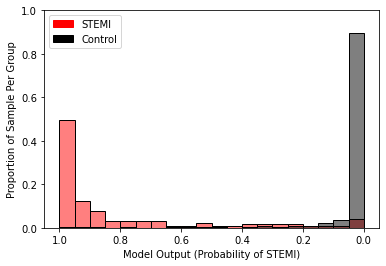

In [149]:
import matplotlib.patches as mpatches

# create color patches for the labels
stemi_patch = mpatches.Patch(color='red', label='STEMI')
control_patch = mpatches.Patch(color='black', label='Control')

sns.histplot(data = stemi, bins = 5, binwidth = 0.05, color = "Red", legend="STEMI", stat = "probability", alpha=0.5, multiple='dodge')
sns.histplot(data = control, bins = 5, binwidth = 0.05,  color = "Black", legend="Control", stat = "probability", alpha=0.5, multiple='dodge')      
# add the legend with the color patches
plt.legend(handles=[stemi_patch, control_patch])

# create and add the labels with the color patches
#plt.text(0.05, -0.2, 'Control:', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
#plt.text(0.15, -0.2, 'STEMI:', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.gca().add_patch(mpatches.Rectangle((0.11, -0.25), 0.05, 0.05, alpha=0.5, facecolor='red'))
plt.gca().add_patch(mpatches.Rectangle((0.01, -0.25), 0.05, 0.05, alpha=0.5, facecolor='black'))

# set the x and y limits and labels
plt.xlim([1.05,-0.05])  
plt.ylim([0.0, 1.]) 
plt.xlabel("Model Output (Probability of STEMI)", size=10)    
plt.ylabel("Proportion of Sample Per Group", size=10) 

# show the plot
plt.show()

In [152]:
min(stemi)

1.8102580860268614e-06

In [154]:
max(stemi)

0.9996342539787293

In [155]:
df_test

Probs    Label
0     0.748707    STEMI
1     0.684489    STEMI
2     0.469005  Control
3     0.917230    STEMI
4     0.986734    STEMI
...        ...      ...
1313  0.000110  Control
1314  0.002511  Control
1315  0.517593    STEMI
1316  0.101810    STEMI
1317  0.901839    STEMI

[1318 rows x 2 columns]

In [168]:
df_test.loc[df_test['Label']=='STEMI', ['Probs']].idxmin()

Probs    97
dtype: int64

In [172]:
df_test.loc[df_test['Label']=='STEMI', ['Probs']].idxmax()

Probs    81
dtype: int64

In [156]:
df_test[df_test['Probs'] == 1.8102580860268614e-06]

Probs  Label
97  0.000002  STEMI

In [157]:
df_test[df_test['Probs'] == 0.9996342539787293]

Probs  Label
81  0.999634  STEMI

In [165]:
df_test.iloc[1162]

Probs        0.0
Label    Control
Name: 1162, dtype: object

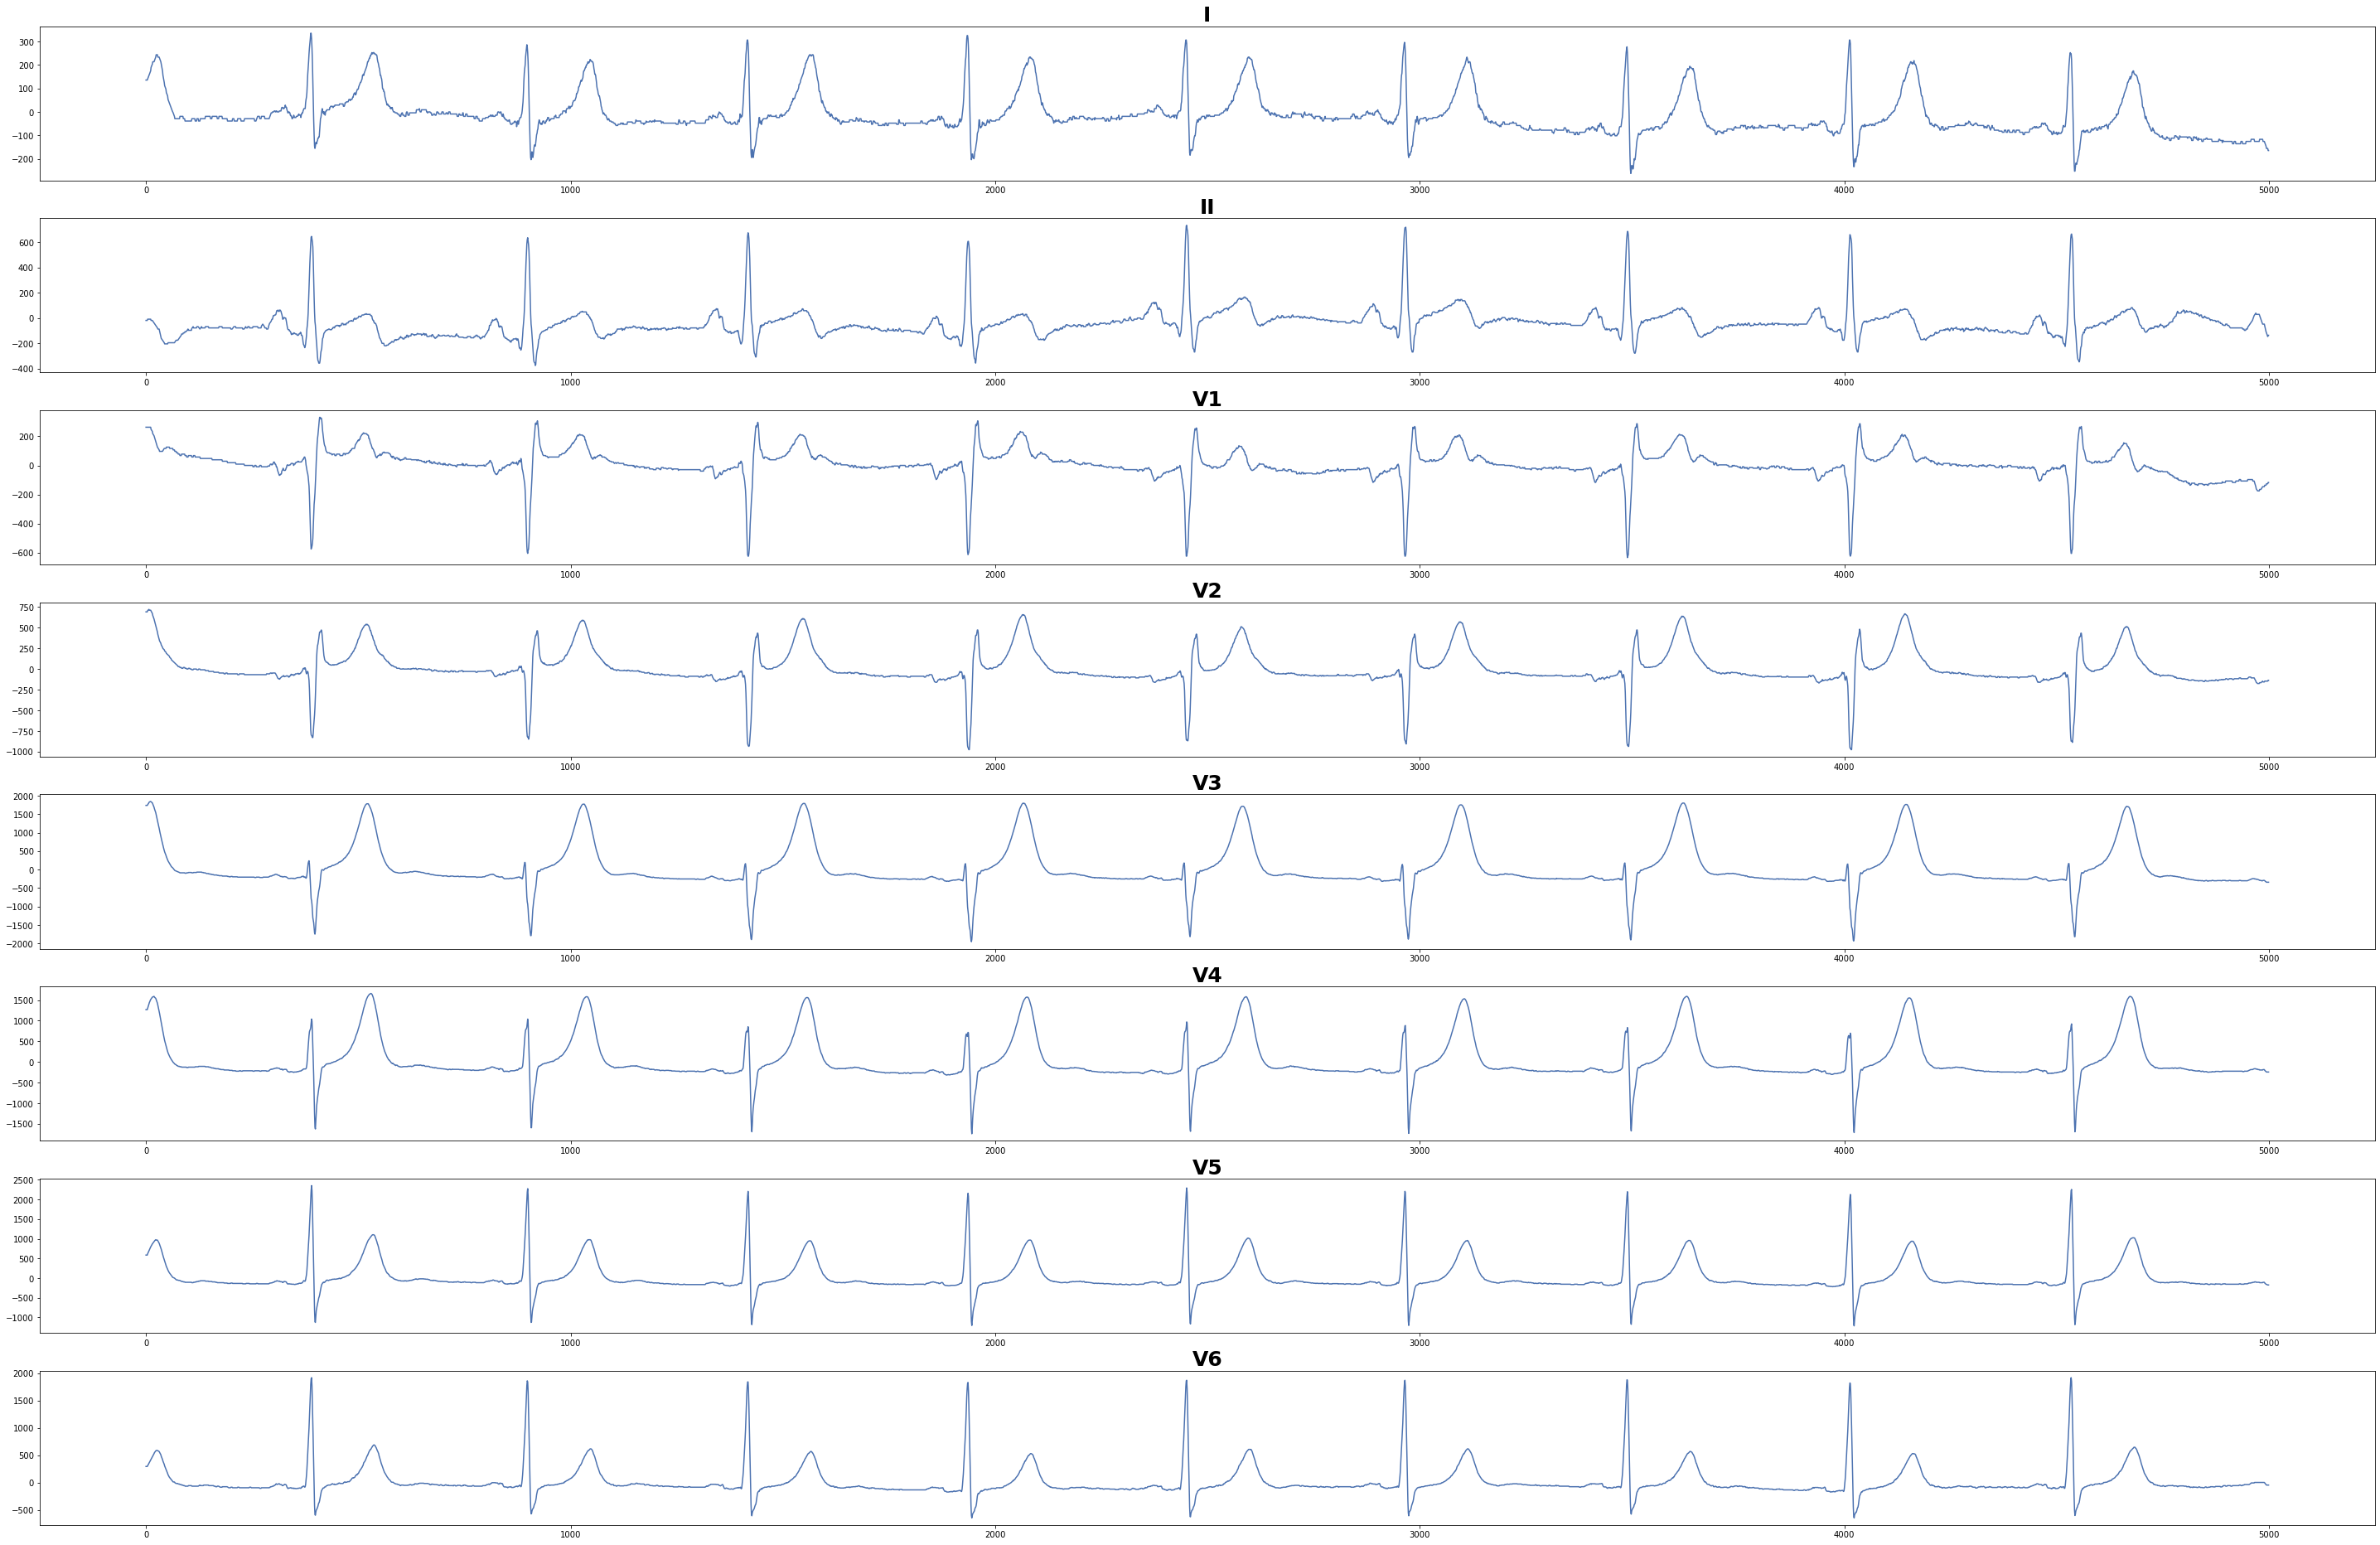

In [176]:
show_waveform(97)

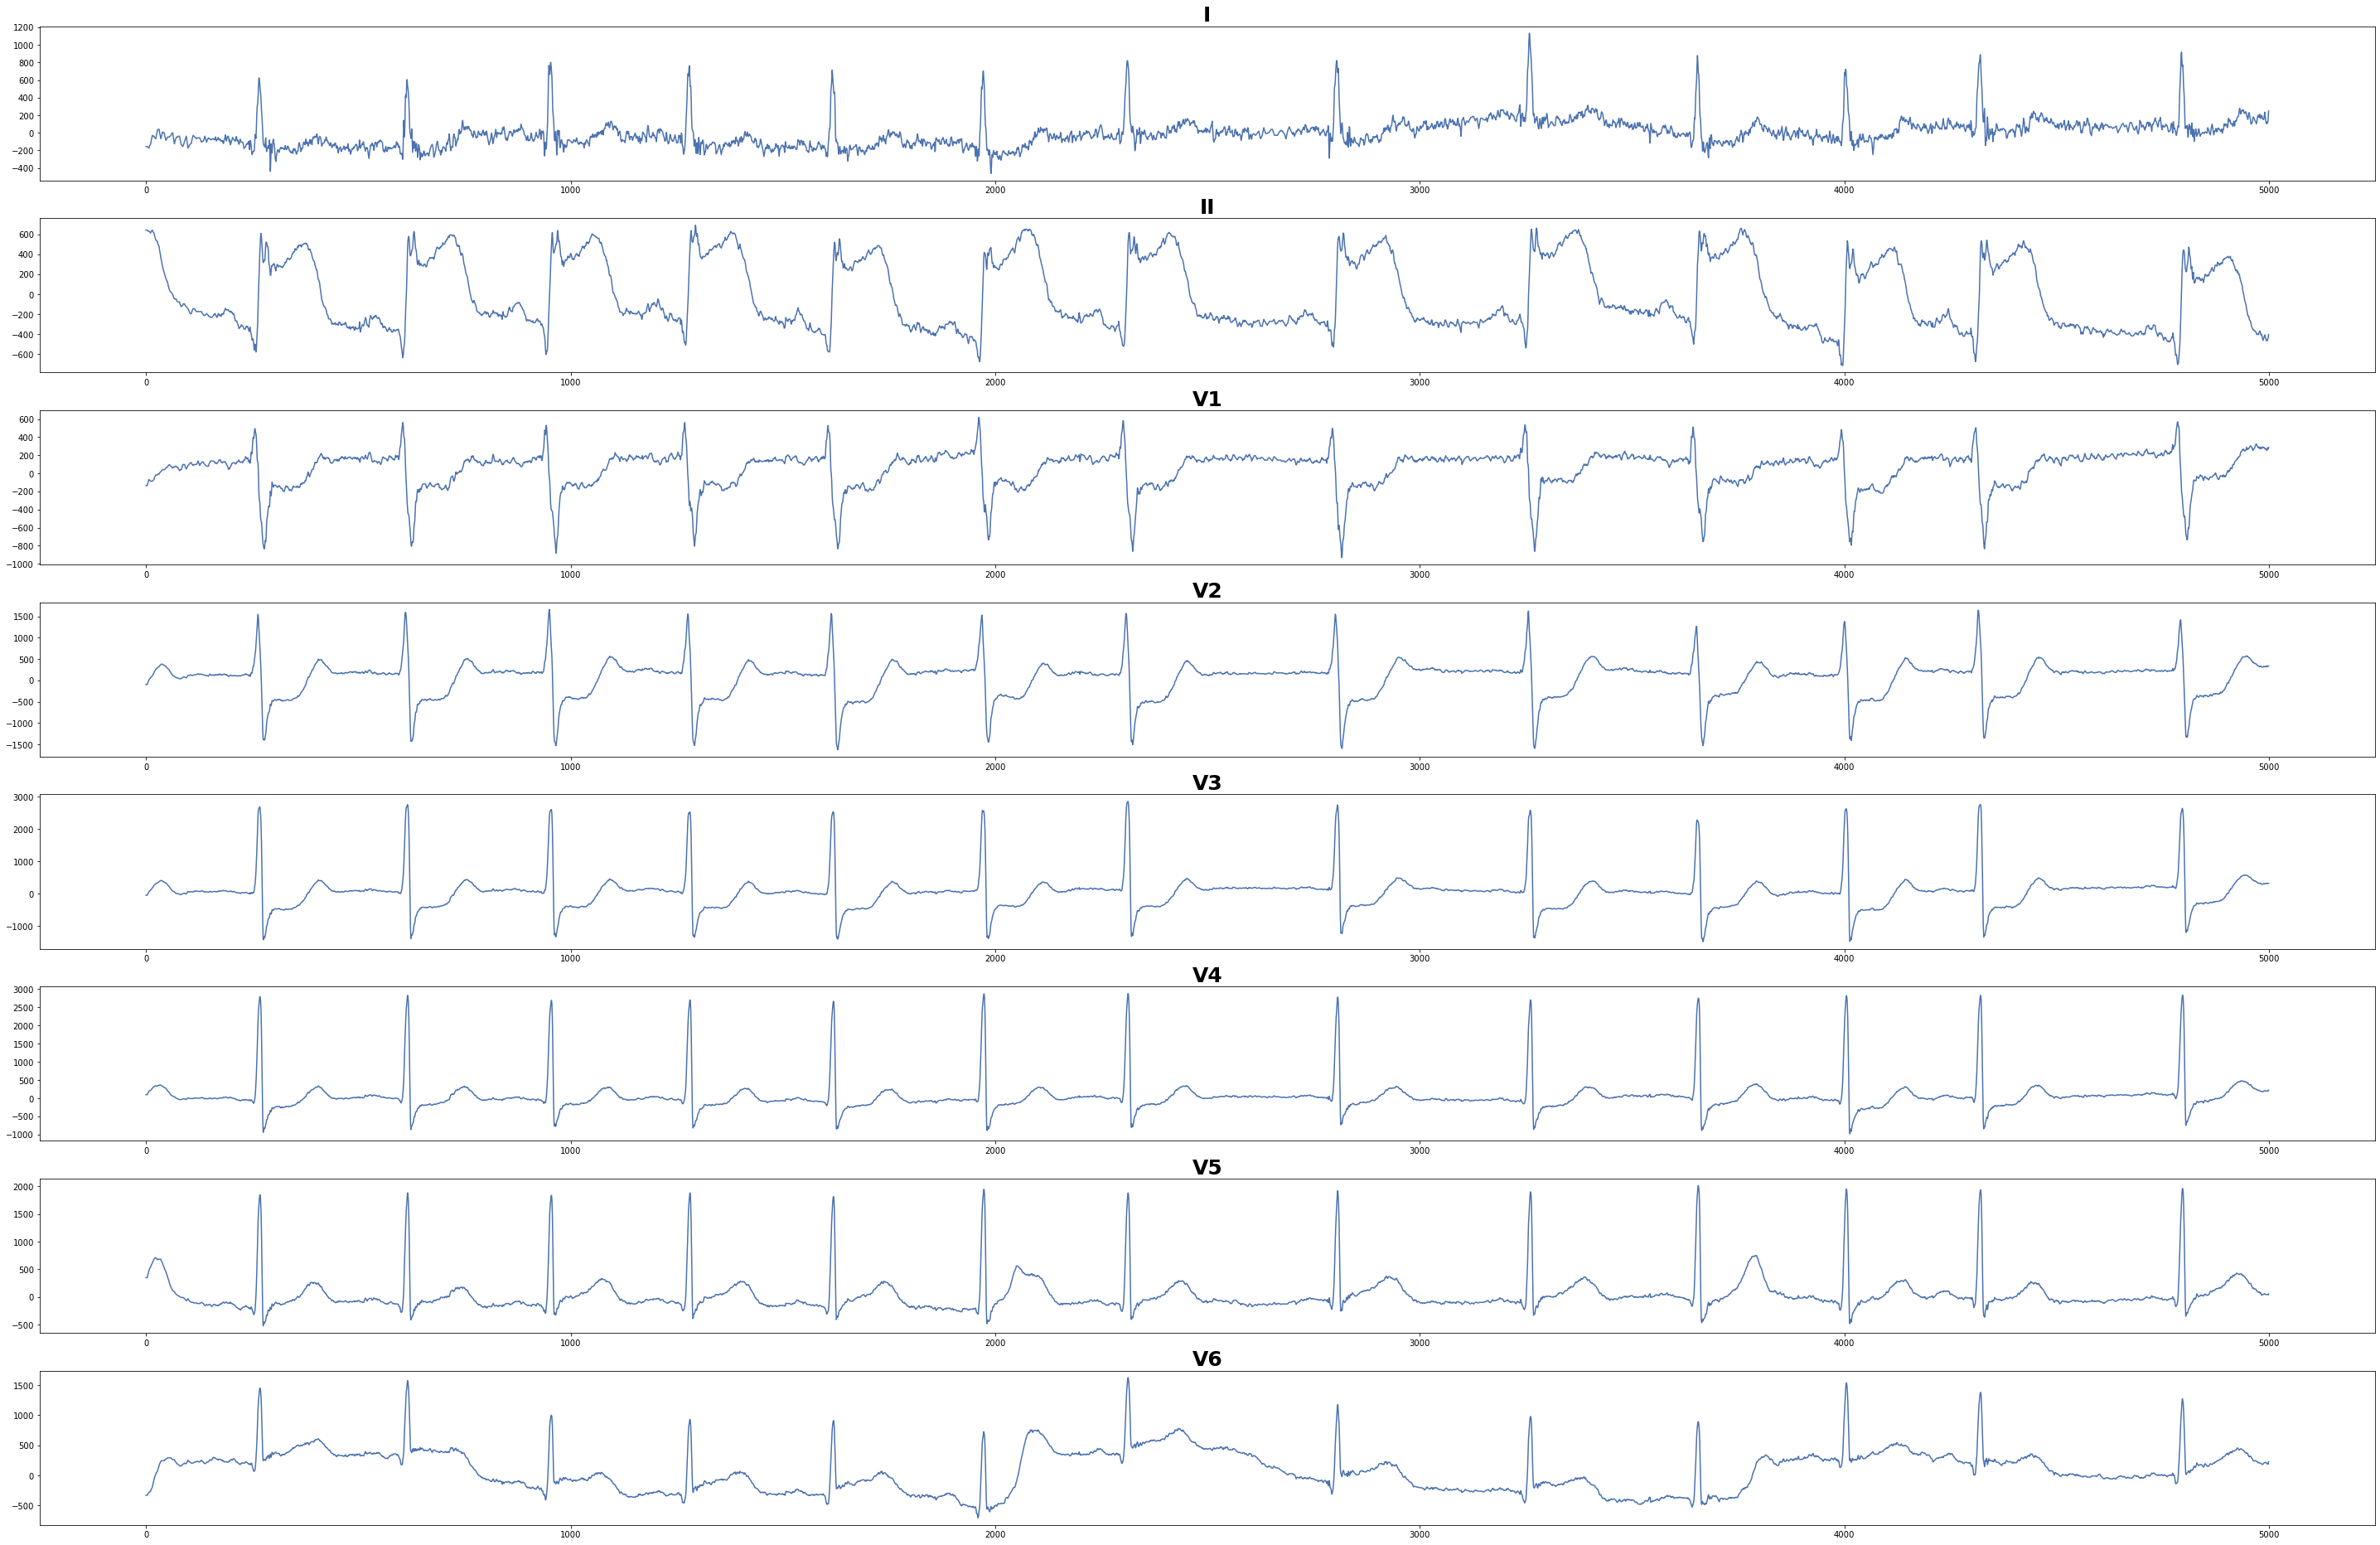

In [175]:
show_waveform(81)

In [173]:
def show_waveform(i):
    df_x = pd.DataFrame(X_test[i])
    lead_I = df_x[0].to_numpy()
    lead_II = df_x[1].to_numpy()
    lead_V1 = df_x[2].to_numpy()
    lead_V2 = df_x[3].to_numpy()
    lead_V3 = df_x[4].to_numpy()
    lead_V4 = df_x[5].to_numpy()
    lead_V5 = df_x[6].to_numpy()
    lead_V6 = df_x[7].to_numpy()   
    
    size = (40,30)
    font_size = 25
    fig, ax = plt.subplots(8, 1)   
    #plt.suptitle('[ChartNo] '+ str(wrong_pt_ls[i]) + '   [Date] ' + str(wrong_dt_ls[i]) + '     (True: STEMI / Predicted: Non-STEMI)', position=(0.5,0.95), fontweight='bold',fontsize=font_size*1.5)
    
    
    ax[0].plot(lead_I)
    ax[0].set_title('I',fontweight="bold", size=font_size)
    plt.rcParams["figure.figsize"] = size

    ax[1].plot(lead_II)
    ax[1].set_title('II',fontweight="bold", size=font_size)
    plt.rcParams["figure.figsize"] = size

    ax[2].plot(lead_V1)
    ax[2].set_title('V1',fontweight="bold", size=font_size)
    plt.rcParams["figure.figsize"] = size

    ax[3].plot(lead_V2)
    ax[3].set_title('V2',fontweight="bold", size=font_size)
    plt.rcParams["figure.figsize"] = size

    ax[4].plot(lead_V3)
    ax[4].set_title('V3',fontweight="bold", size=font_size)
    plt.rcParams["figure.figsize"] = size

    ax[5].plot(lead_V4)
    ax[5].set_title('V4',fontweight="bold", size=font_size)
    plt.rcParams["figure.figsize"] = size

    ax[6].plot(lead_V5)
    ax[6].set_title('V5',fontweight="bold", size=font_size)
    plt.rcParams["figure.figsize"] = size

    ax[7].plot(lead_V6)
    ax[7].set_title('V6',fontweight="bold", size=font_size)
    plt.rcParams["figure.figsize"] = size
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

In [160]:
ecg_1_lead = pd.DataFrame(X_test[97])
ecg_1_lead.shape

(5000, 8)

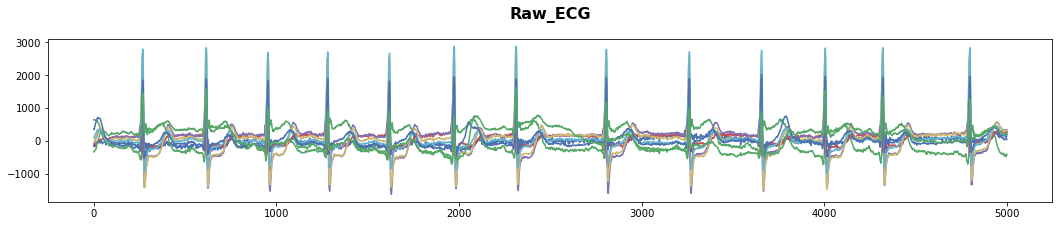

In [177]:
ecg_2_lead = pd.DataFrame(X_test[81])
ecg_2_lead.shape
ecg_show(ecg_2_lead)

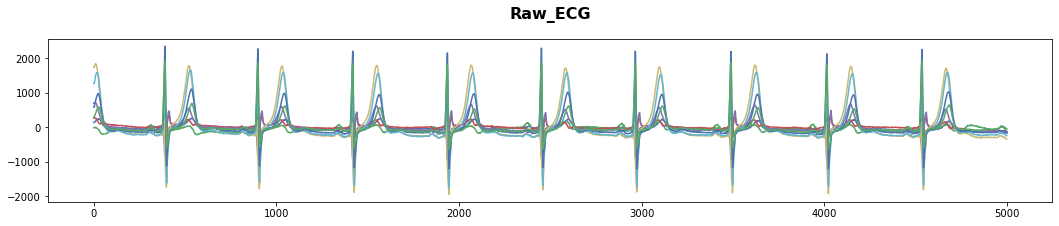

In [161]:
def ecg_show(df):
  title = "Raw_ECG"
  title_font = {
      'fontsize':16,
      'fontweight':'bold'
  }
  plt.figure(figsize=(18,3))
  plt.title(title, fontdict=title_font, loc='center', pad=20)
  plt.plot(df)
  
ecg_show(ecg_1_lead)


In [178]:
def ensemble_gradcam(models, layer_name, data):
    all_heatmaps = []
    for model in models:
        grad_model = tf.keras.models.Model(
            [model.inputs], [model.get_layer(layer_name).output, model.output]
        )
        last_conv_layer_output, preds = grad_model(data)

        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(data)
            pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        grads = tape.gradient(class_channel, last_conv_layer_output)

        pooled_grads = tf.reduce_mean(grads, axis=(0))

        last_conv_layer_output = last_conv_layer_output[0]

        heatmap = last_conv_layer_output * pooled_grads
        heatmap = tf.reduce_mean(heatmap, axis=(1))
        heatmap = np.expand_dims(heatmap,0)
        
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        all_heatmaps.append(heatmap.numpy())
        
    ensemble_heatmap = np.mean(all_heatmaps, axis=0)
        
    return ensemble_heatmap

models = de_model
layer_name = "conv1d_9"
label = ["Control", "Stemi"]

In [179]:
def gcperlead(idx):
    data = X_test[idx]
    data = np.expand_dims(data, 0)
    label = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    fig, axs = plt.subplots(nrows=8, ncols=1, figsize=(30,40))
    heatmap = ensemble_gradcam(models, layer_name, data)
    heatmap = np.uint8(255 * heatmap)
    heatmap = Image.fromarray(heatmap).resize((5000, 1))
    for i, lead in enumerate(label):
        axs[i].plot(X_test[idx][:, i], 'k')
        im = axs[i].imshow(np.expand_dims(heatmap,axis=2),cmap='Reds', aspect="auto", interpolation='nearest',extent=[0,5000,data.min(),data.max()],  alpha=0.8)
        axs[i].set_title('Lead '+str(lead), fontdict={'fontsize': 25})
        axs[i].tick_params(axis='both', which = 'major', labelsize=20)
        axs[i].margins(x=0)
    
    # create colorbar
    cbar = fig.colorbar(im, ax=axs.ravel().tolist())
    cbar.ax.tick_params(labelsize=20)
    cbar.ax.set_position([.95, 0.17, 0.015, 1.2])

    # adjust spacing between subplots
    fig.subplots_adjust(hspace = 0.4)
    plt.show()

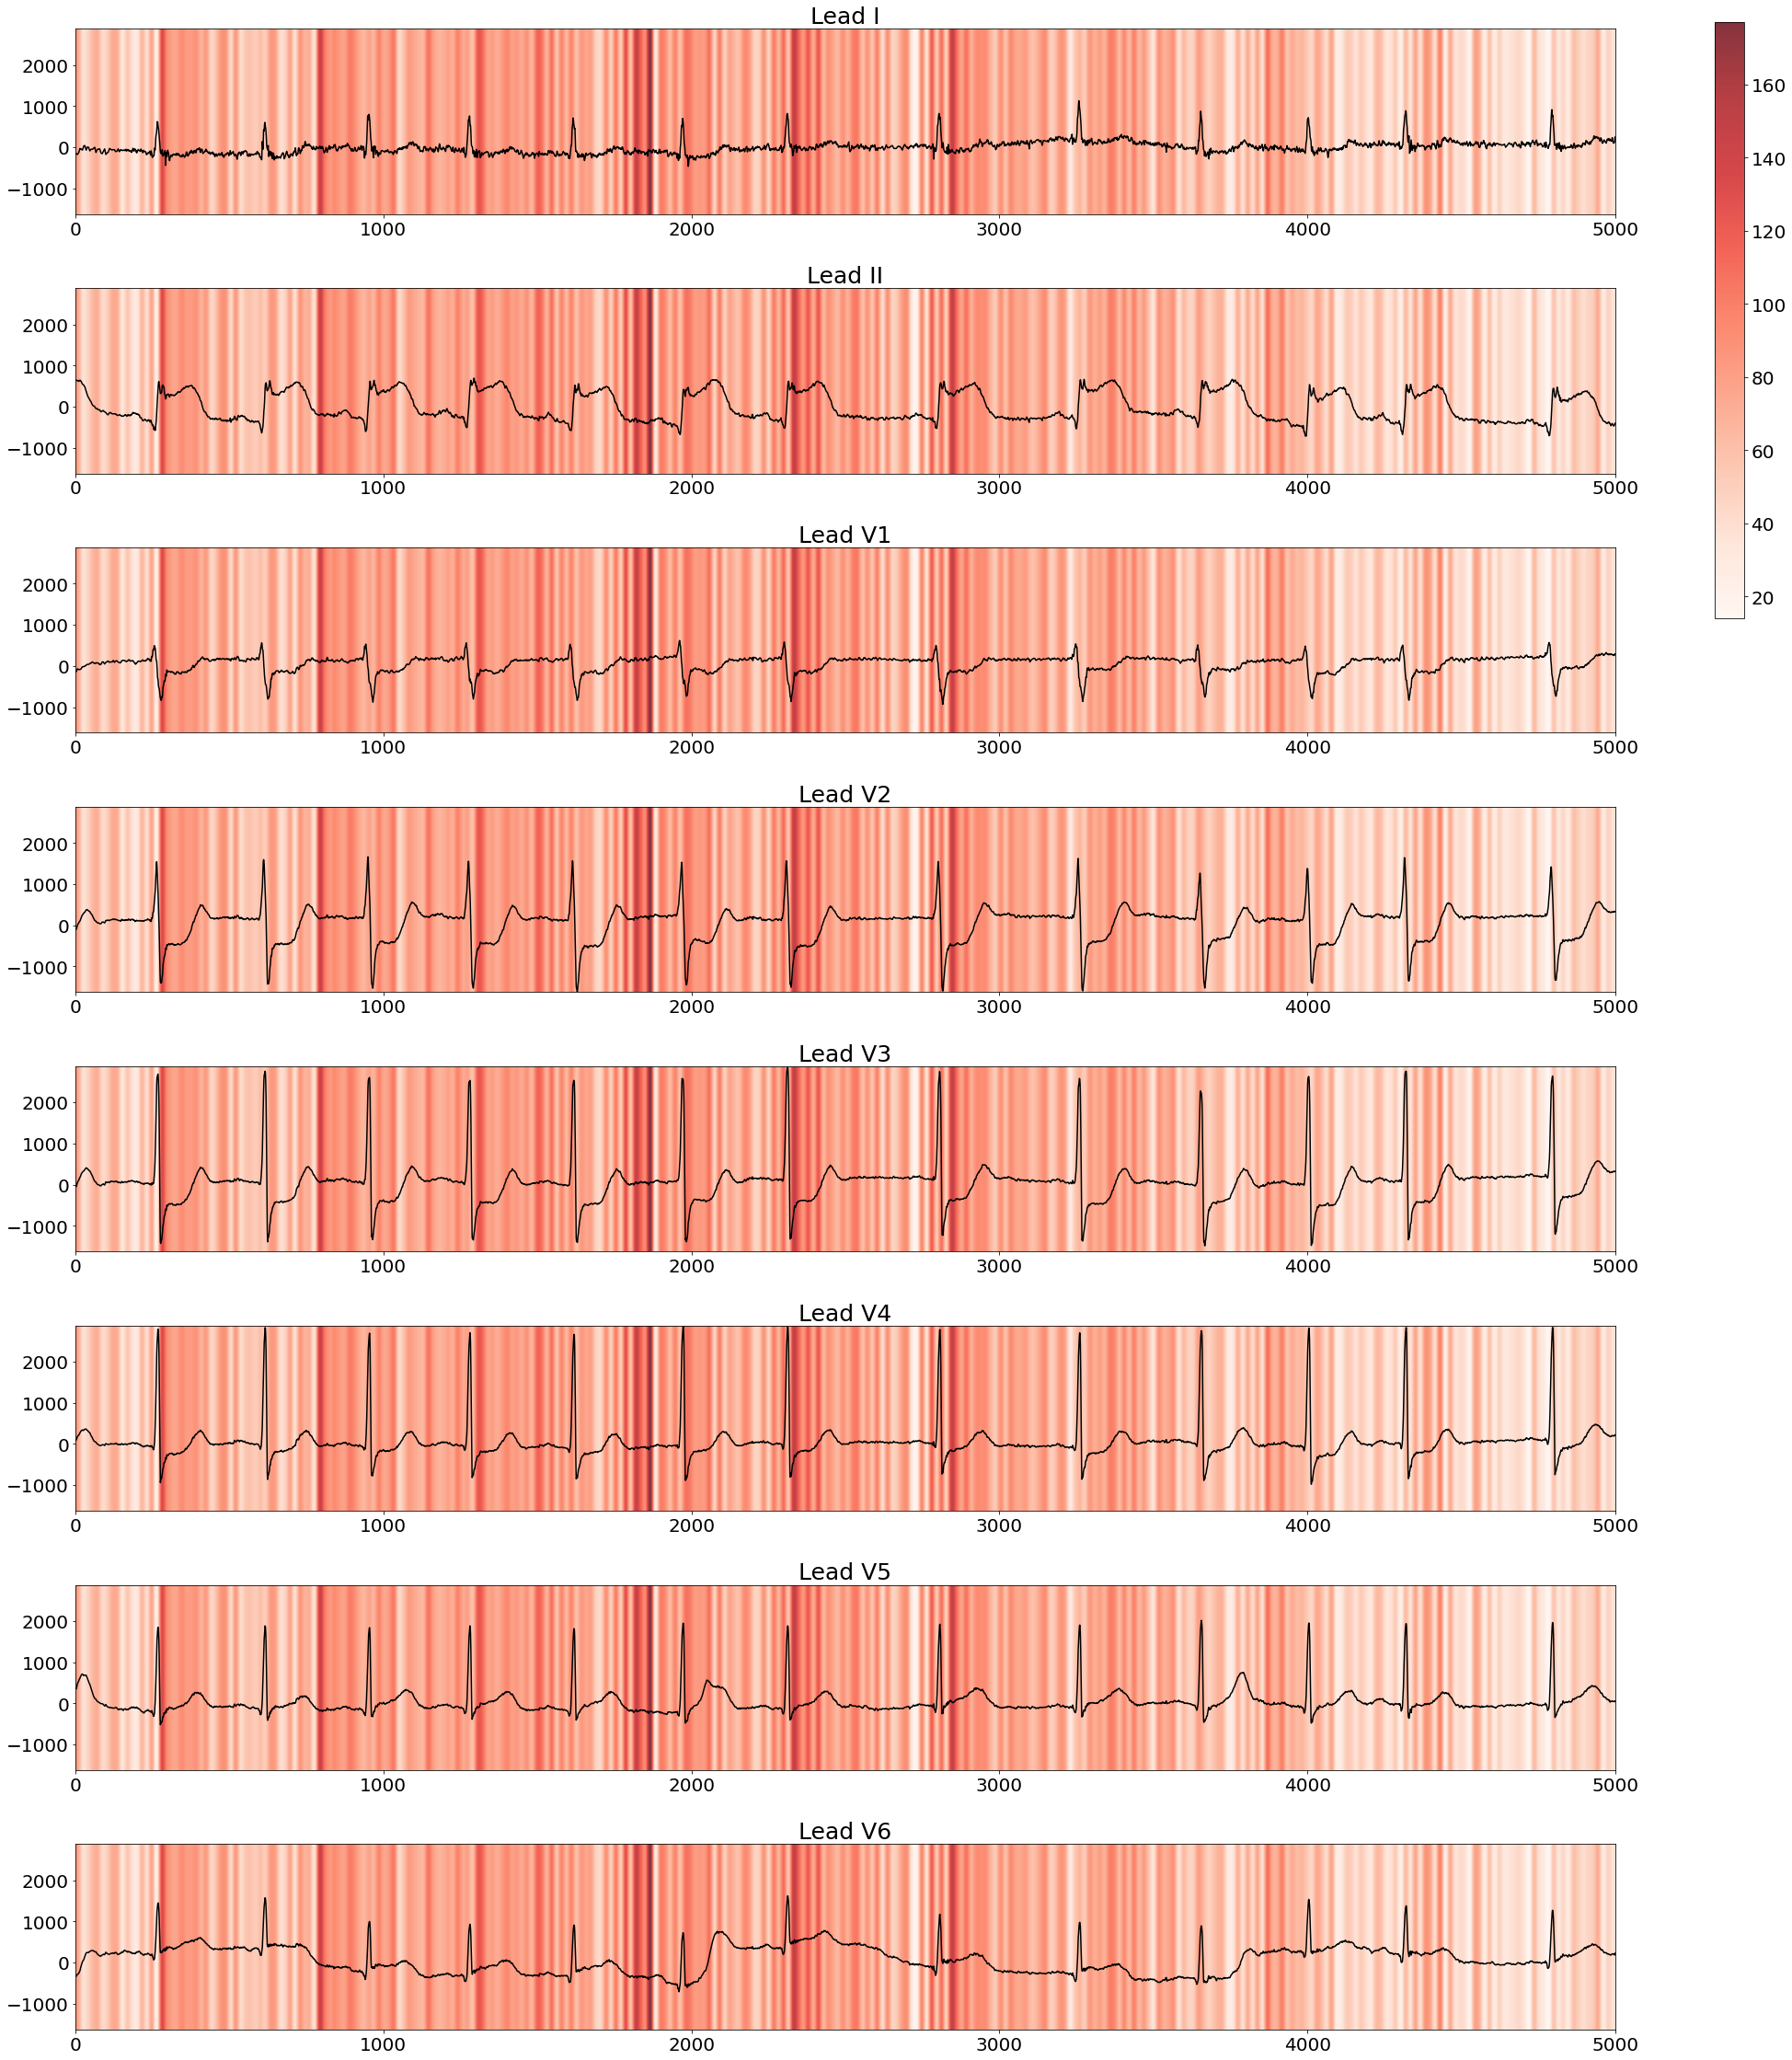

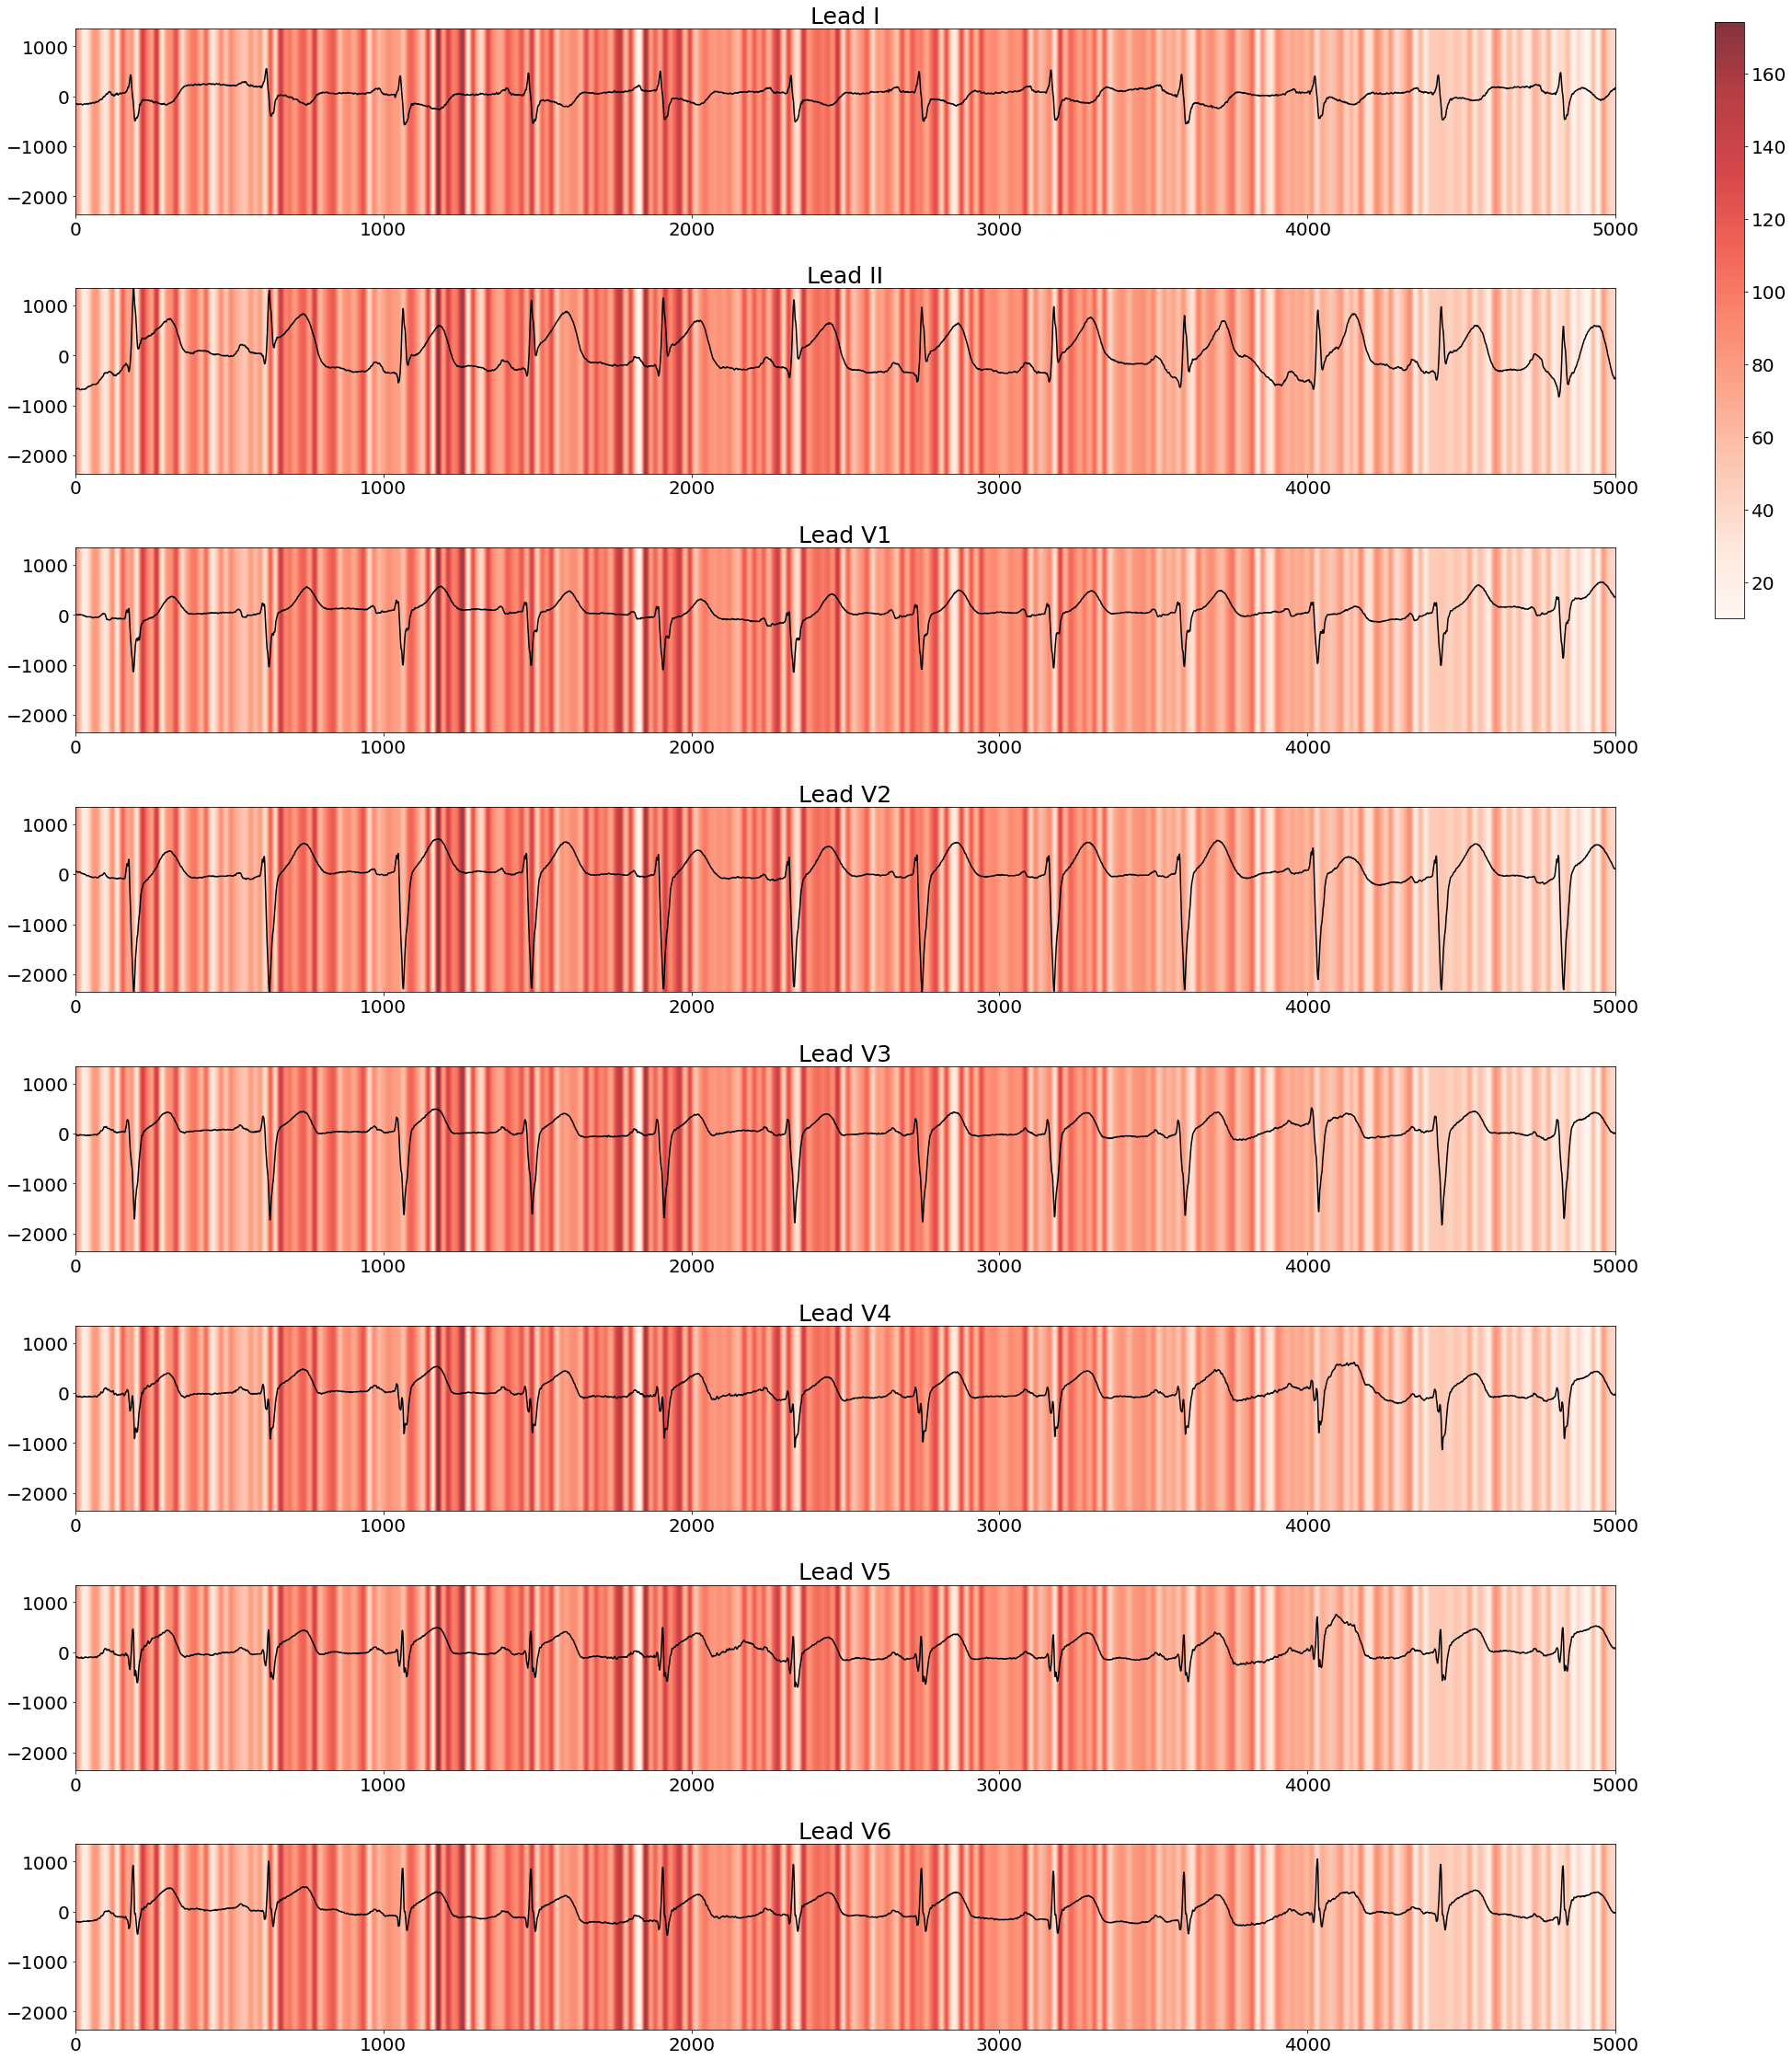

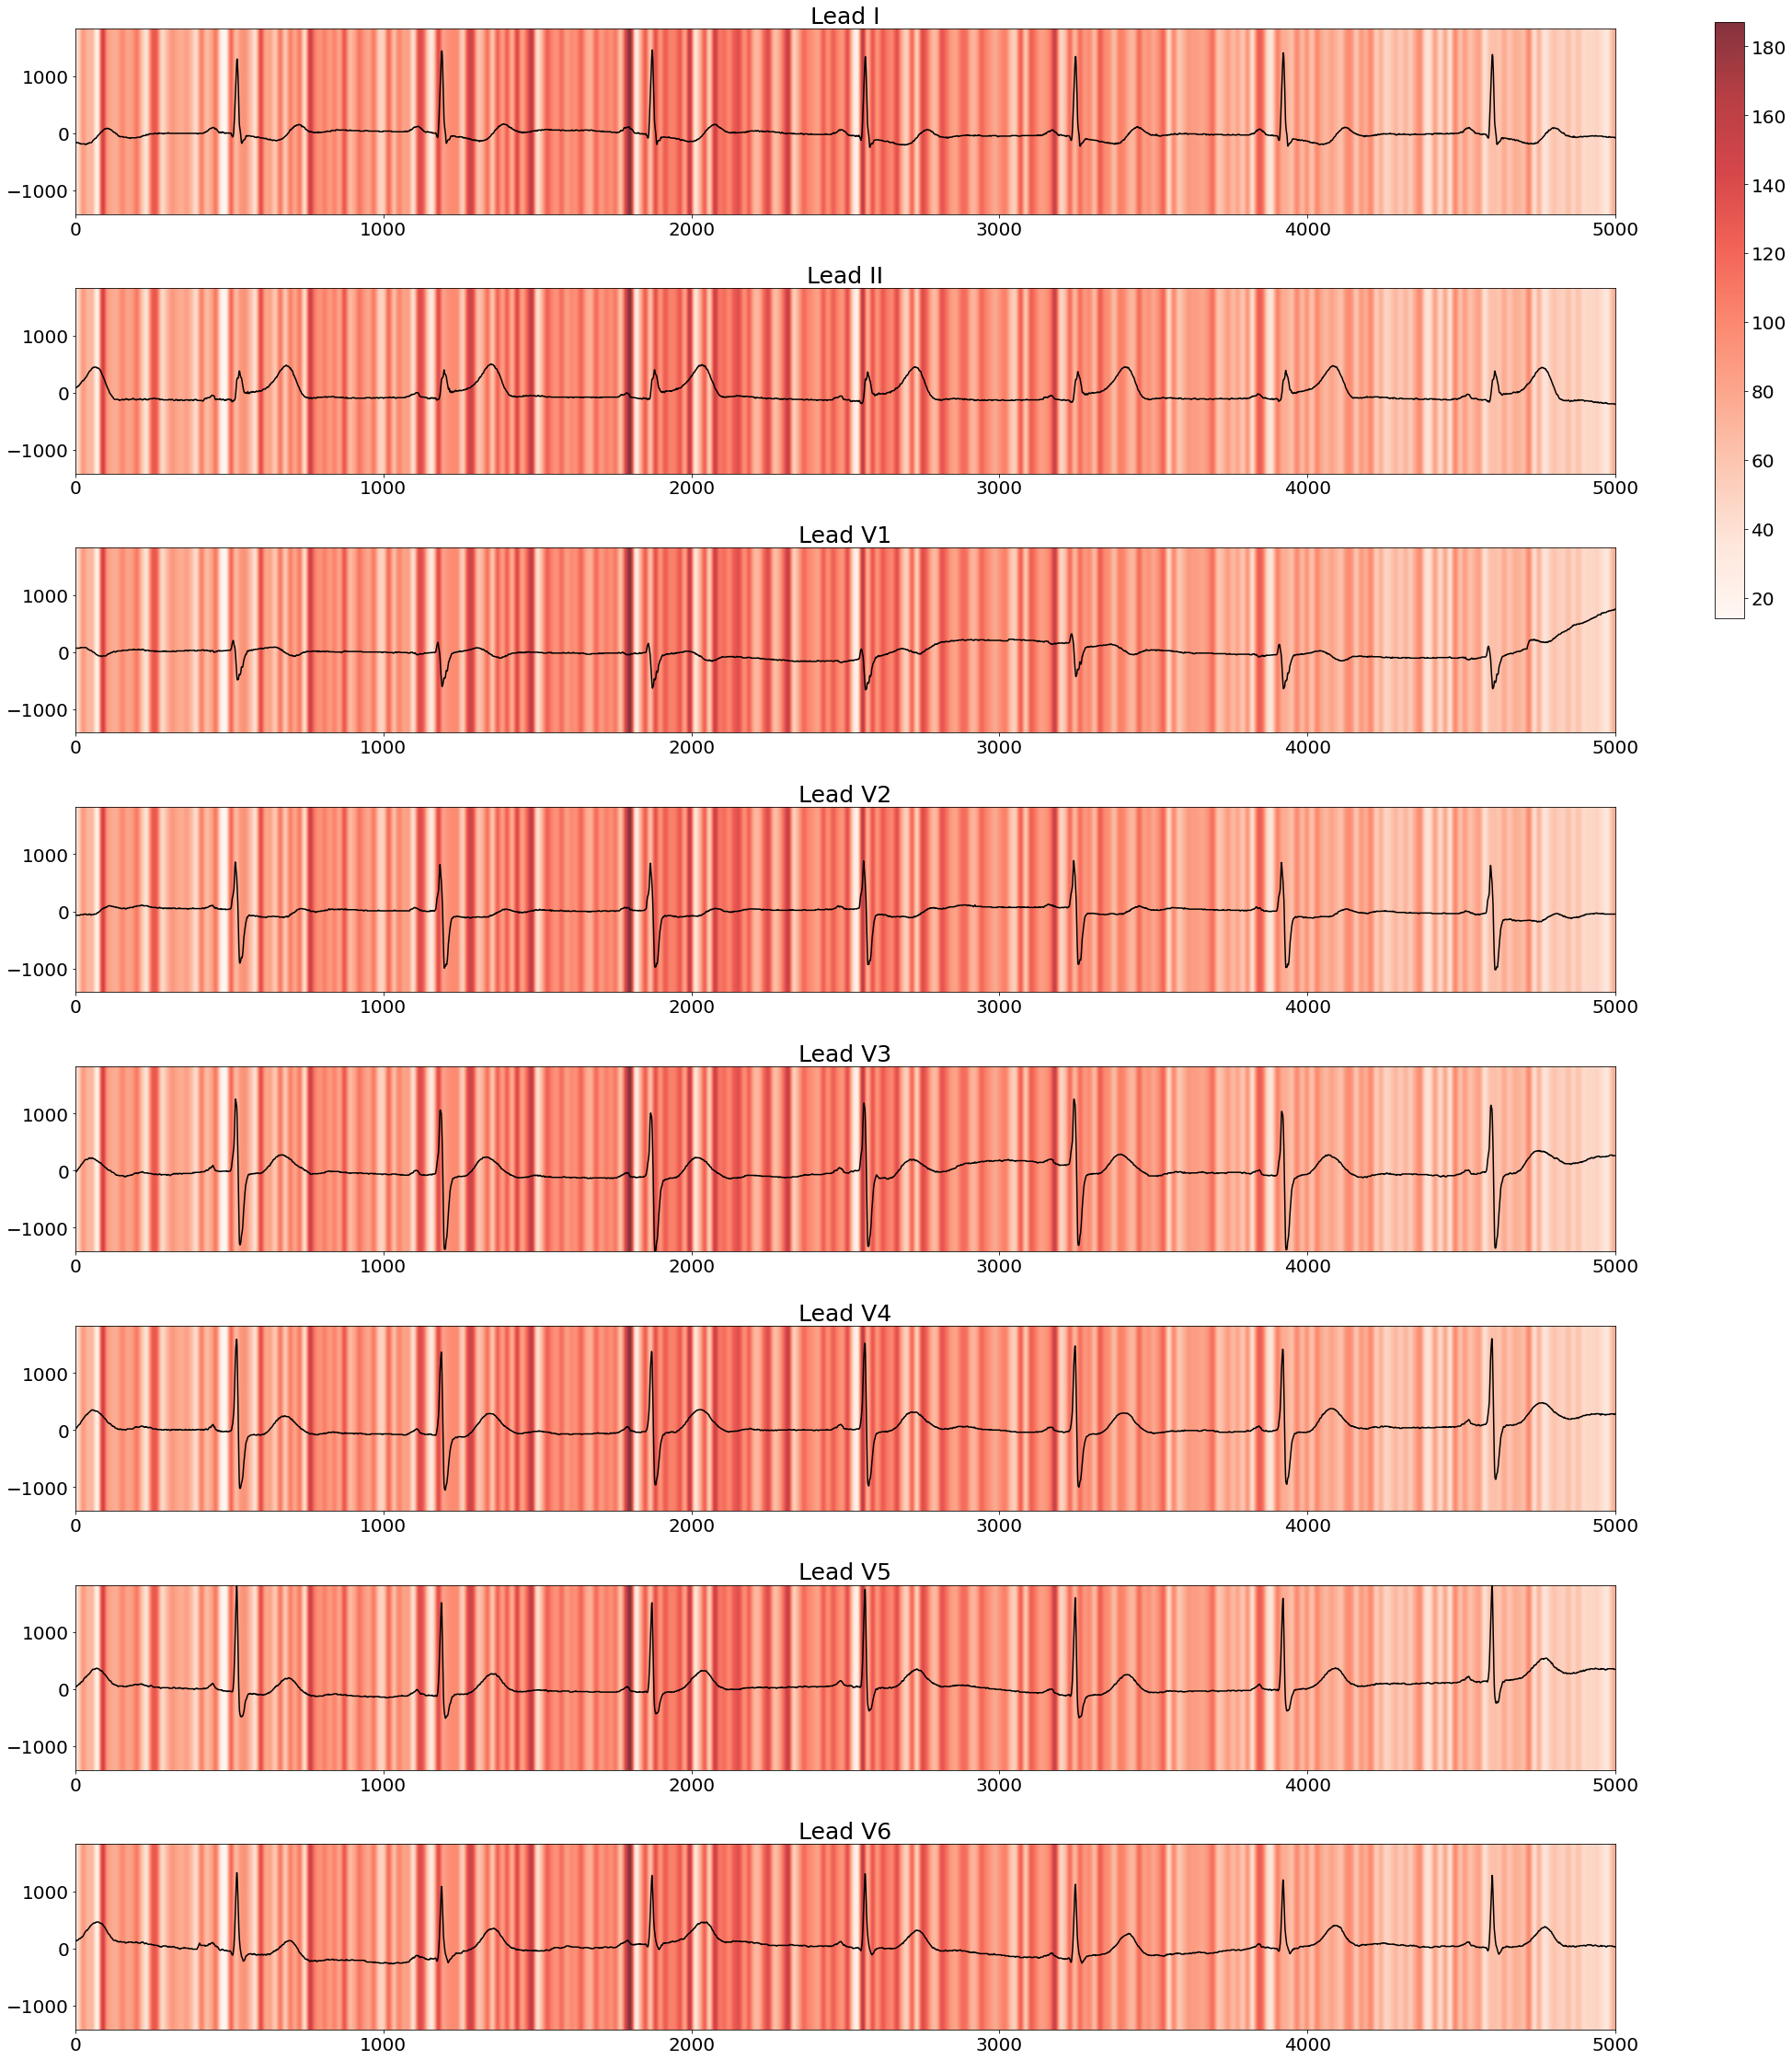

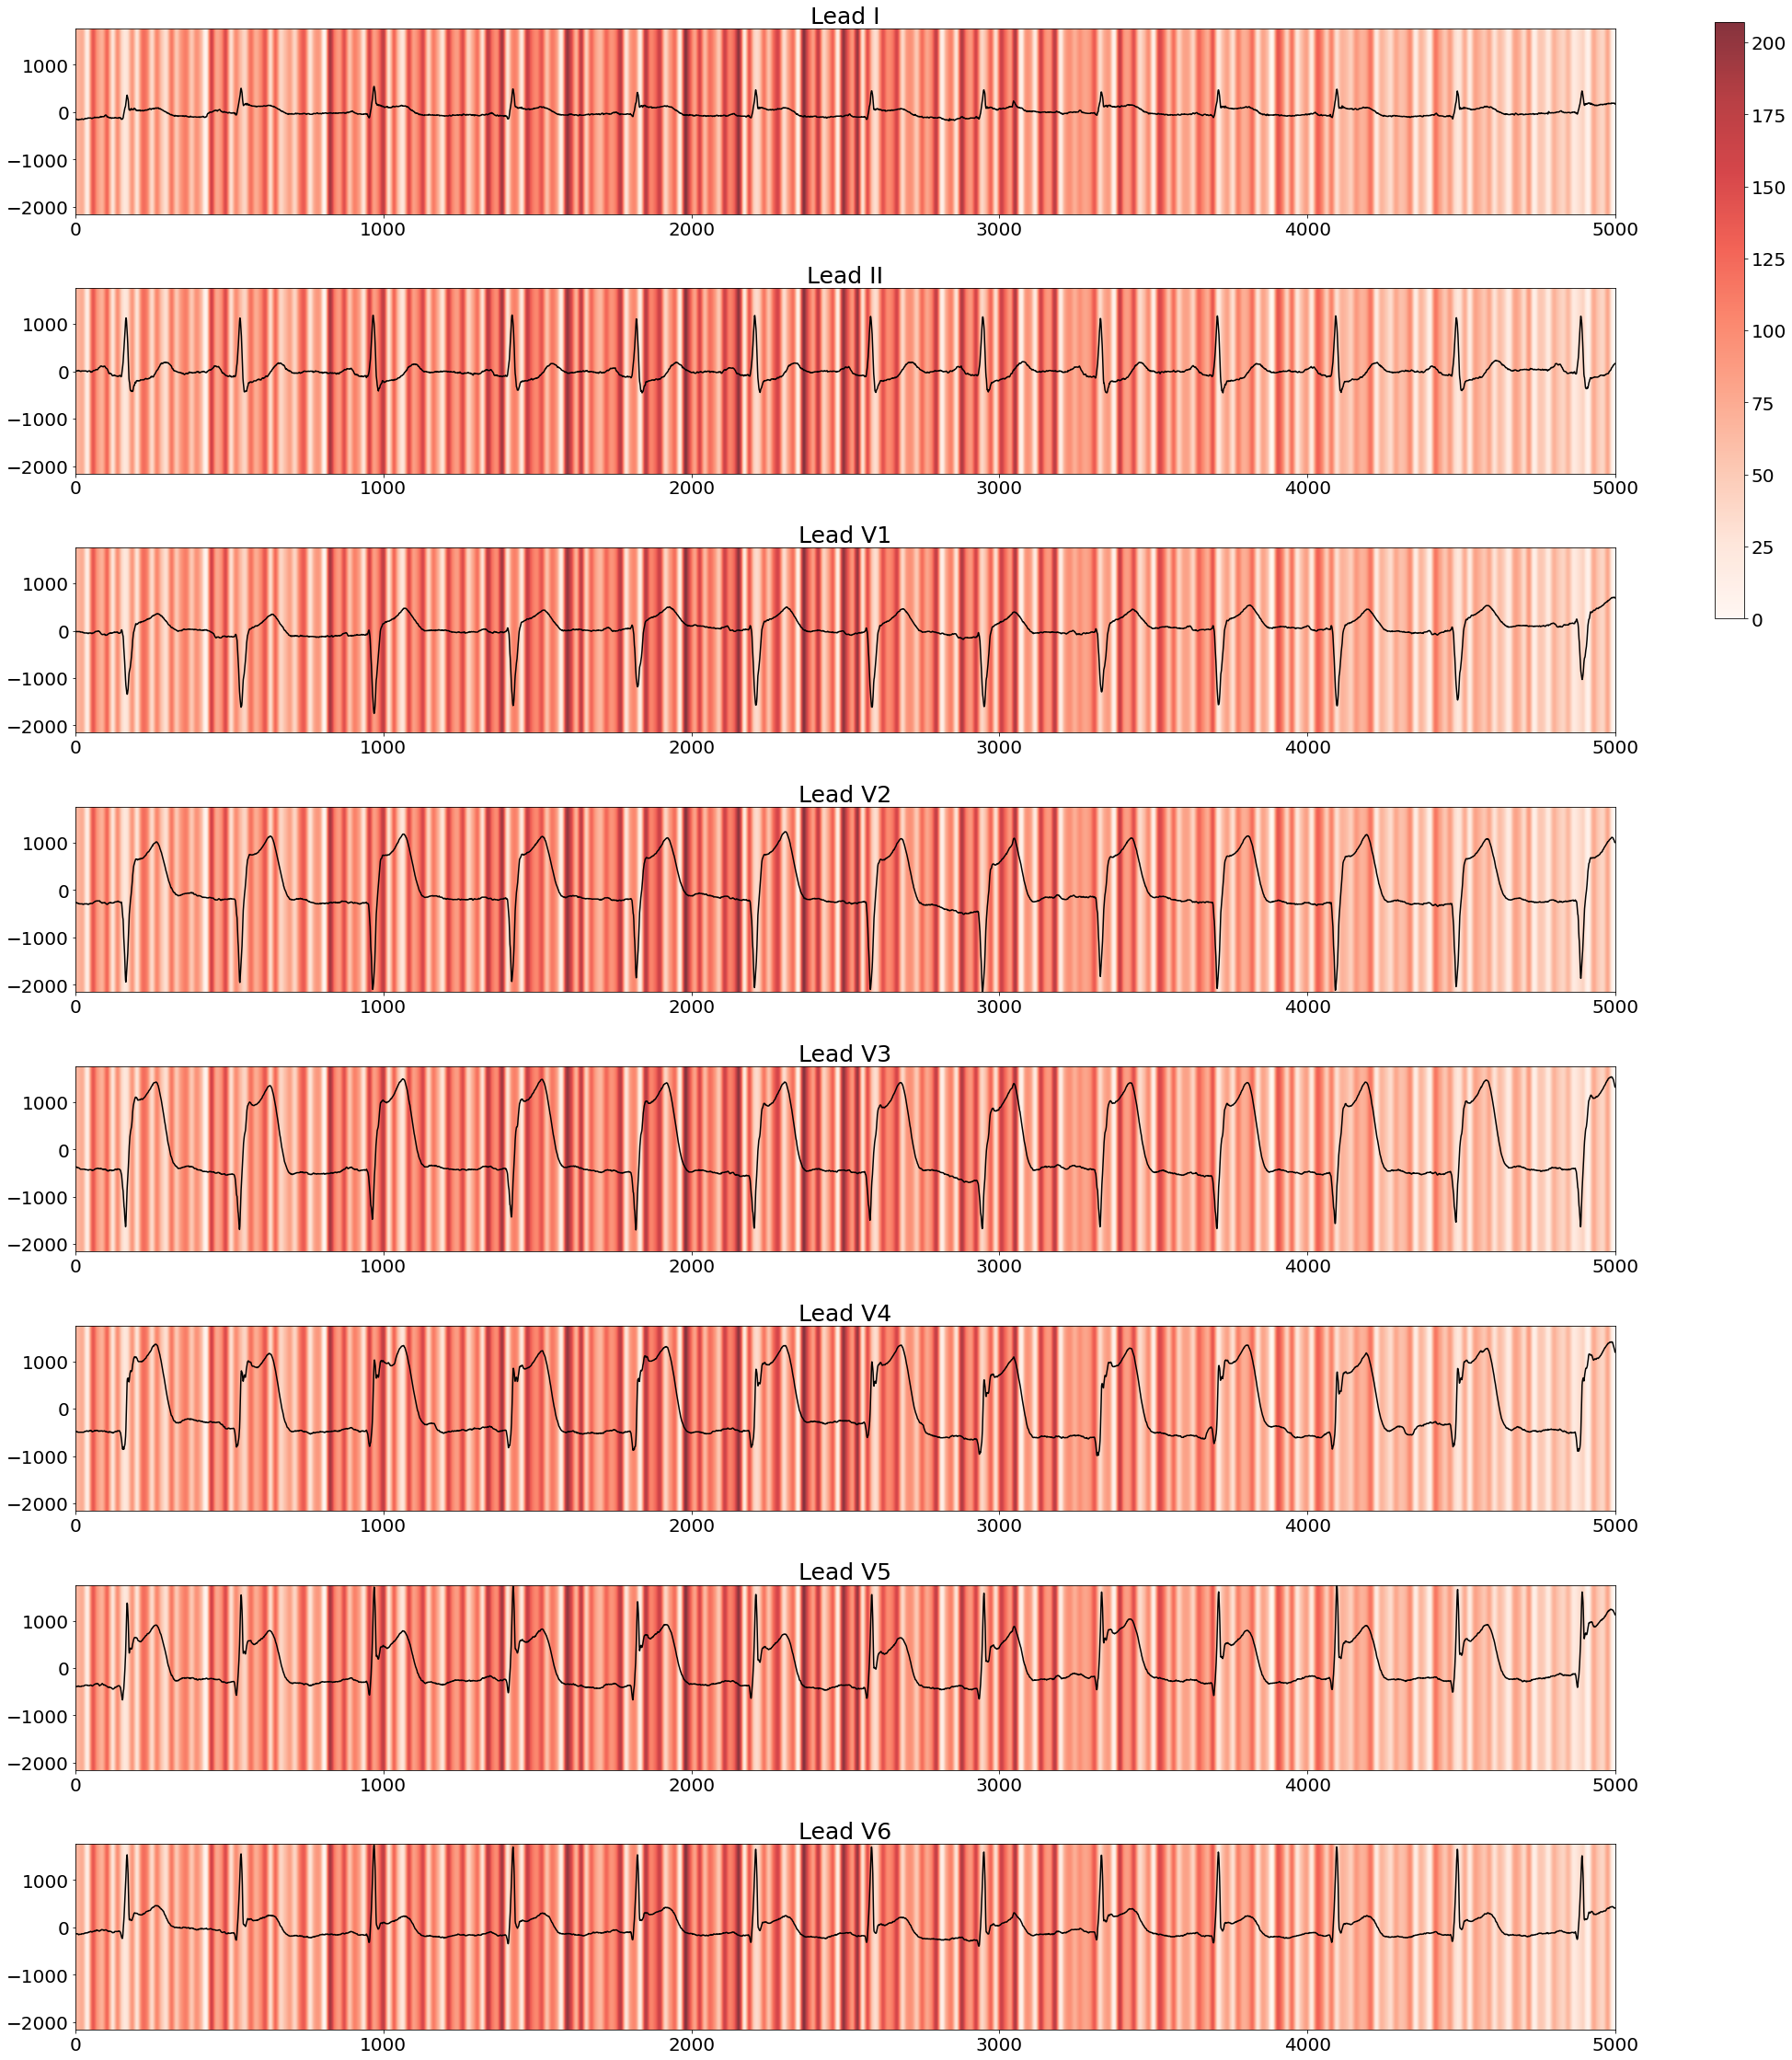

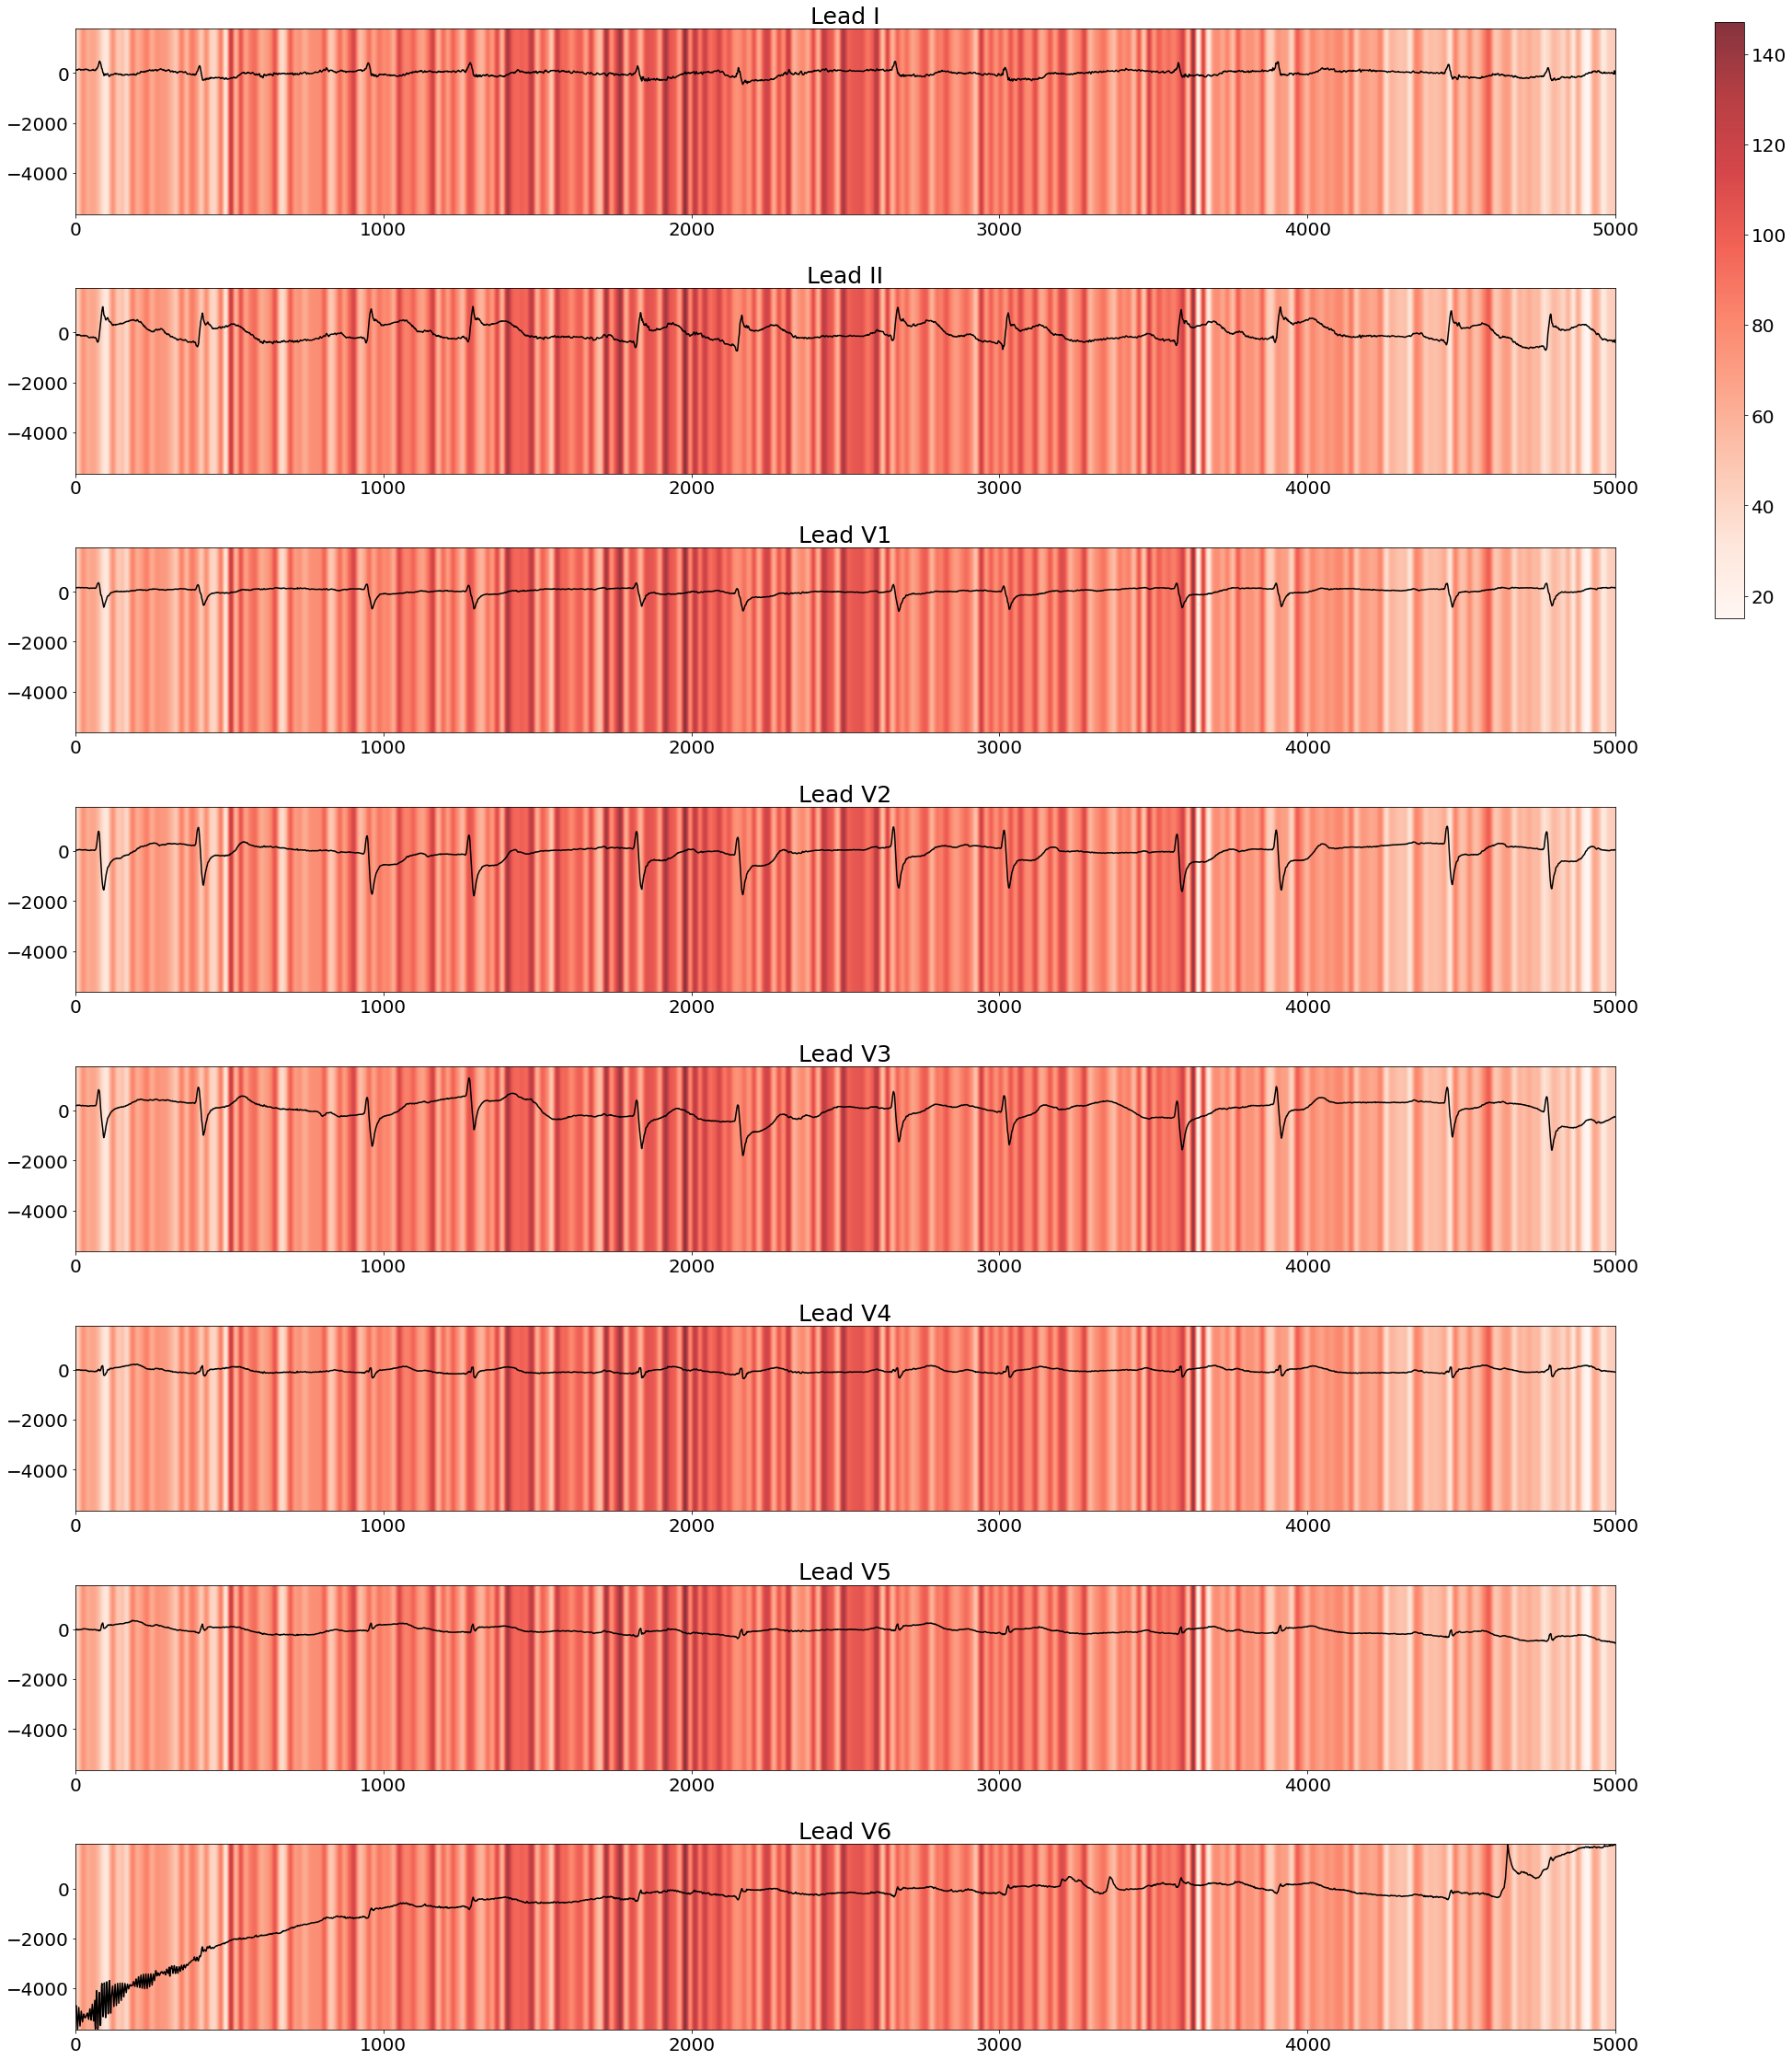

In [205]:
for i in stemi_props1:
    gcperlead(i)

In [182]:
def gcperls(idx_list, lead):
    for i in idx_list:
        image = X_test[i]
        data = np.expand_dims(image, 0)
        heatmap = ensemble_gradcam(models, layer_name, data)
        heatmap = np.uint8(255 * heatmap)
        heatmap = Image.fromarray(heatmap).resize((5000, 1))
        plt.figure(figsize=(30,4))
        plt.plot(X_test[i][:, lead], 'k')
        plt.imshow(np.expand_dims(heatmap,axis=2),cmap='Reds', aspect="auto", interpolation='nearest',extent=[0,5000,data.min(),data.max()],  alpha=0.8)
        plt.colorbar()
        label = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        plt.title('Lead {} ({})'.format(label[lead], i), fontdict={'fontsize': 25})
        print(i)
        plt.show()

In [185]:
stemi_props = df_test[df_test['Label']=='STEMI'].sort_values(by=['Probs']).index
stemi_props

Int64Index([  97,   39,  757,   34,   47,  763, 1316, 1147,   74, 1130,
            ...
              79,   86,   56,   82,   23,   24,   43,  105,  111,   81],
           dtype='int64', length=129)

In [201]:
stemi_props1 = df_test[df_test['Label']=='STEMI'].sort_values(by=['Probs'], ascending=False).index
stemi_props1 = stemi_props1[0:5]

In [202]:
stemi_props1

Int64Index([81, 111, 105, 43, 24], dtype='int64')

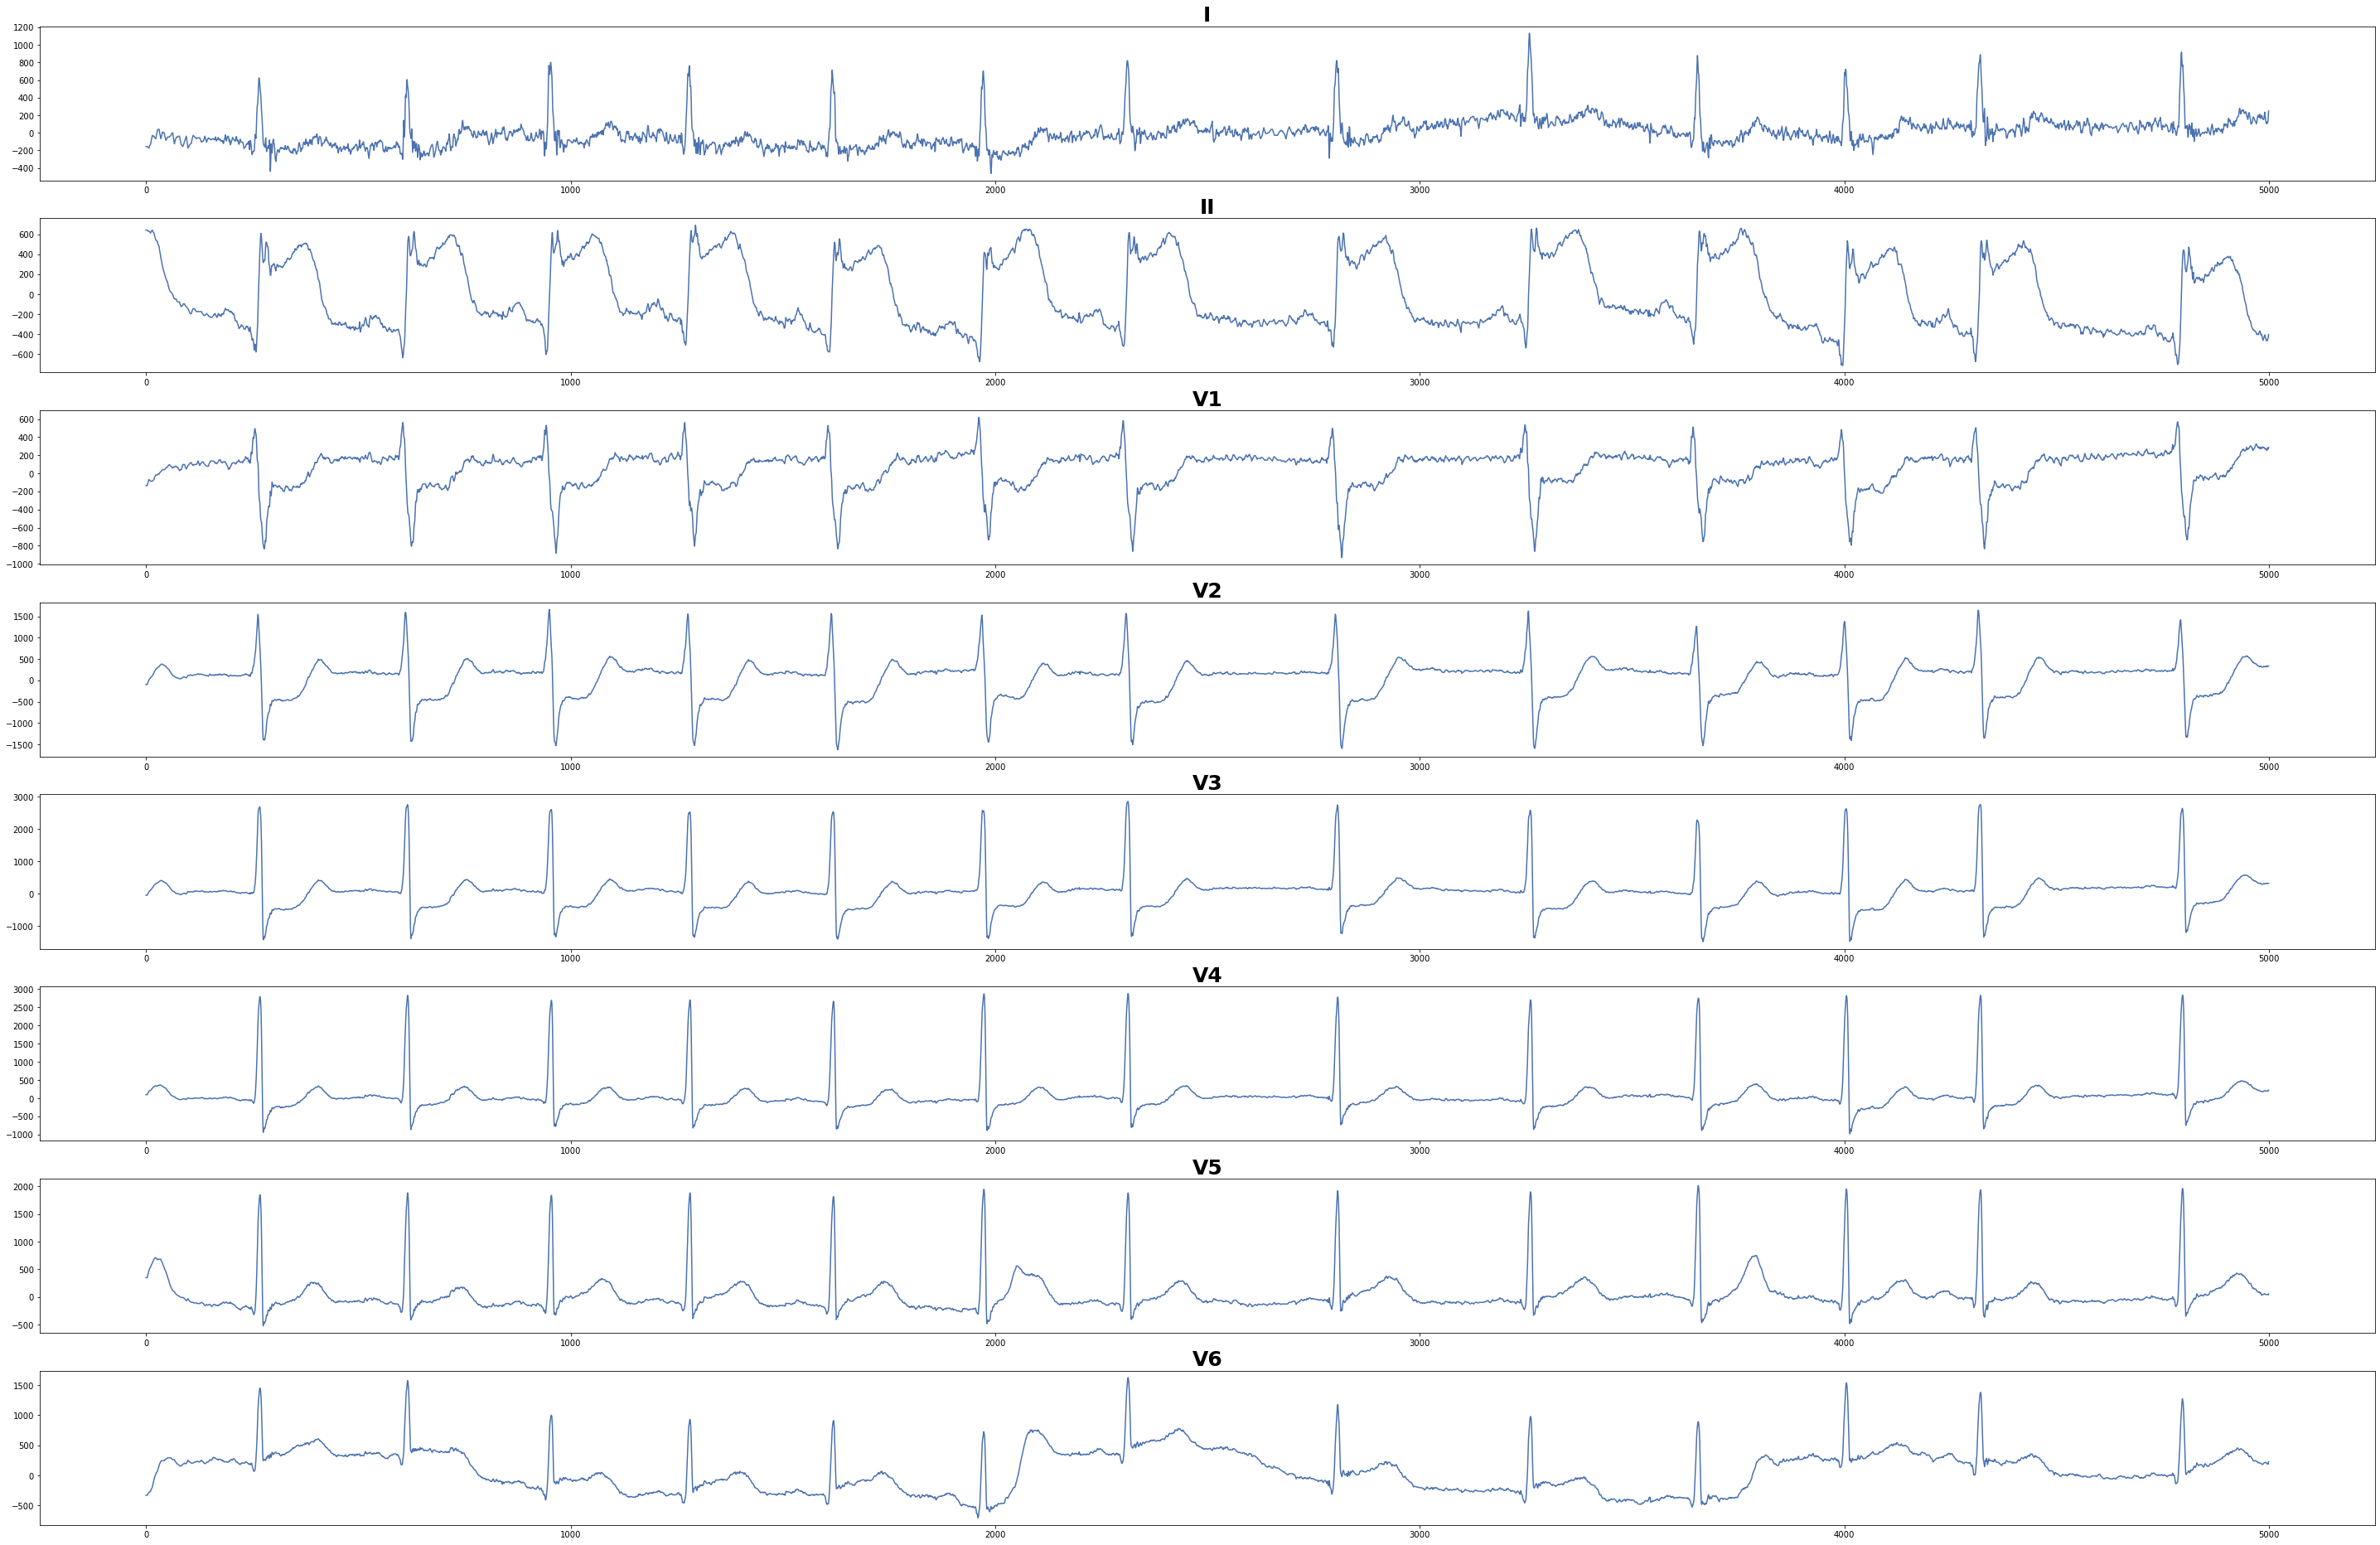

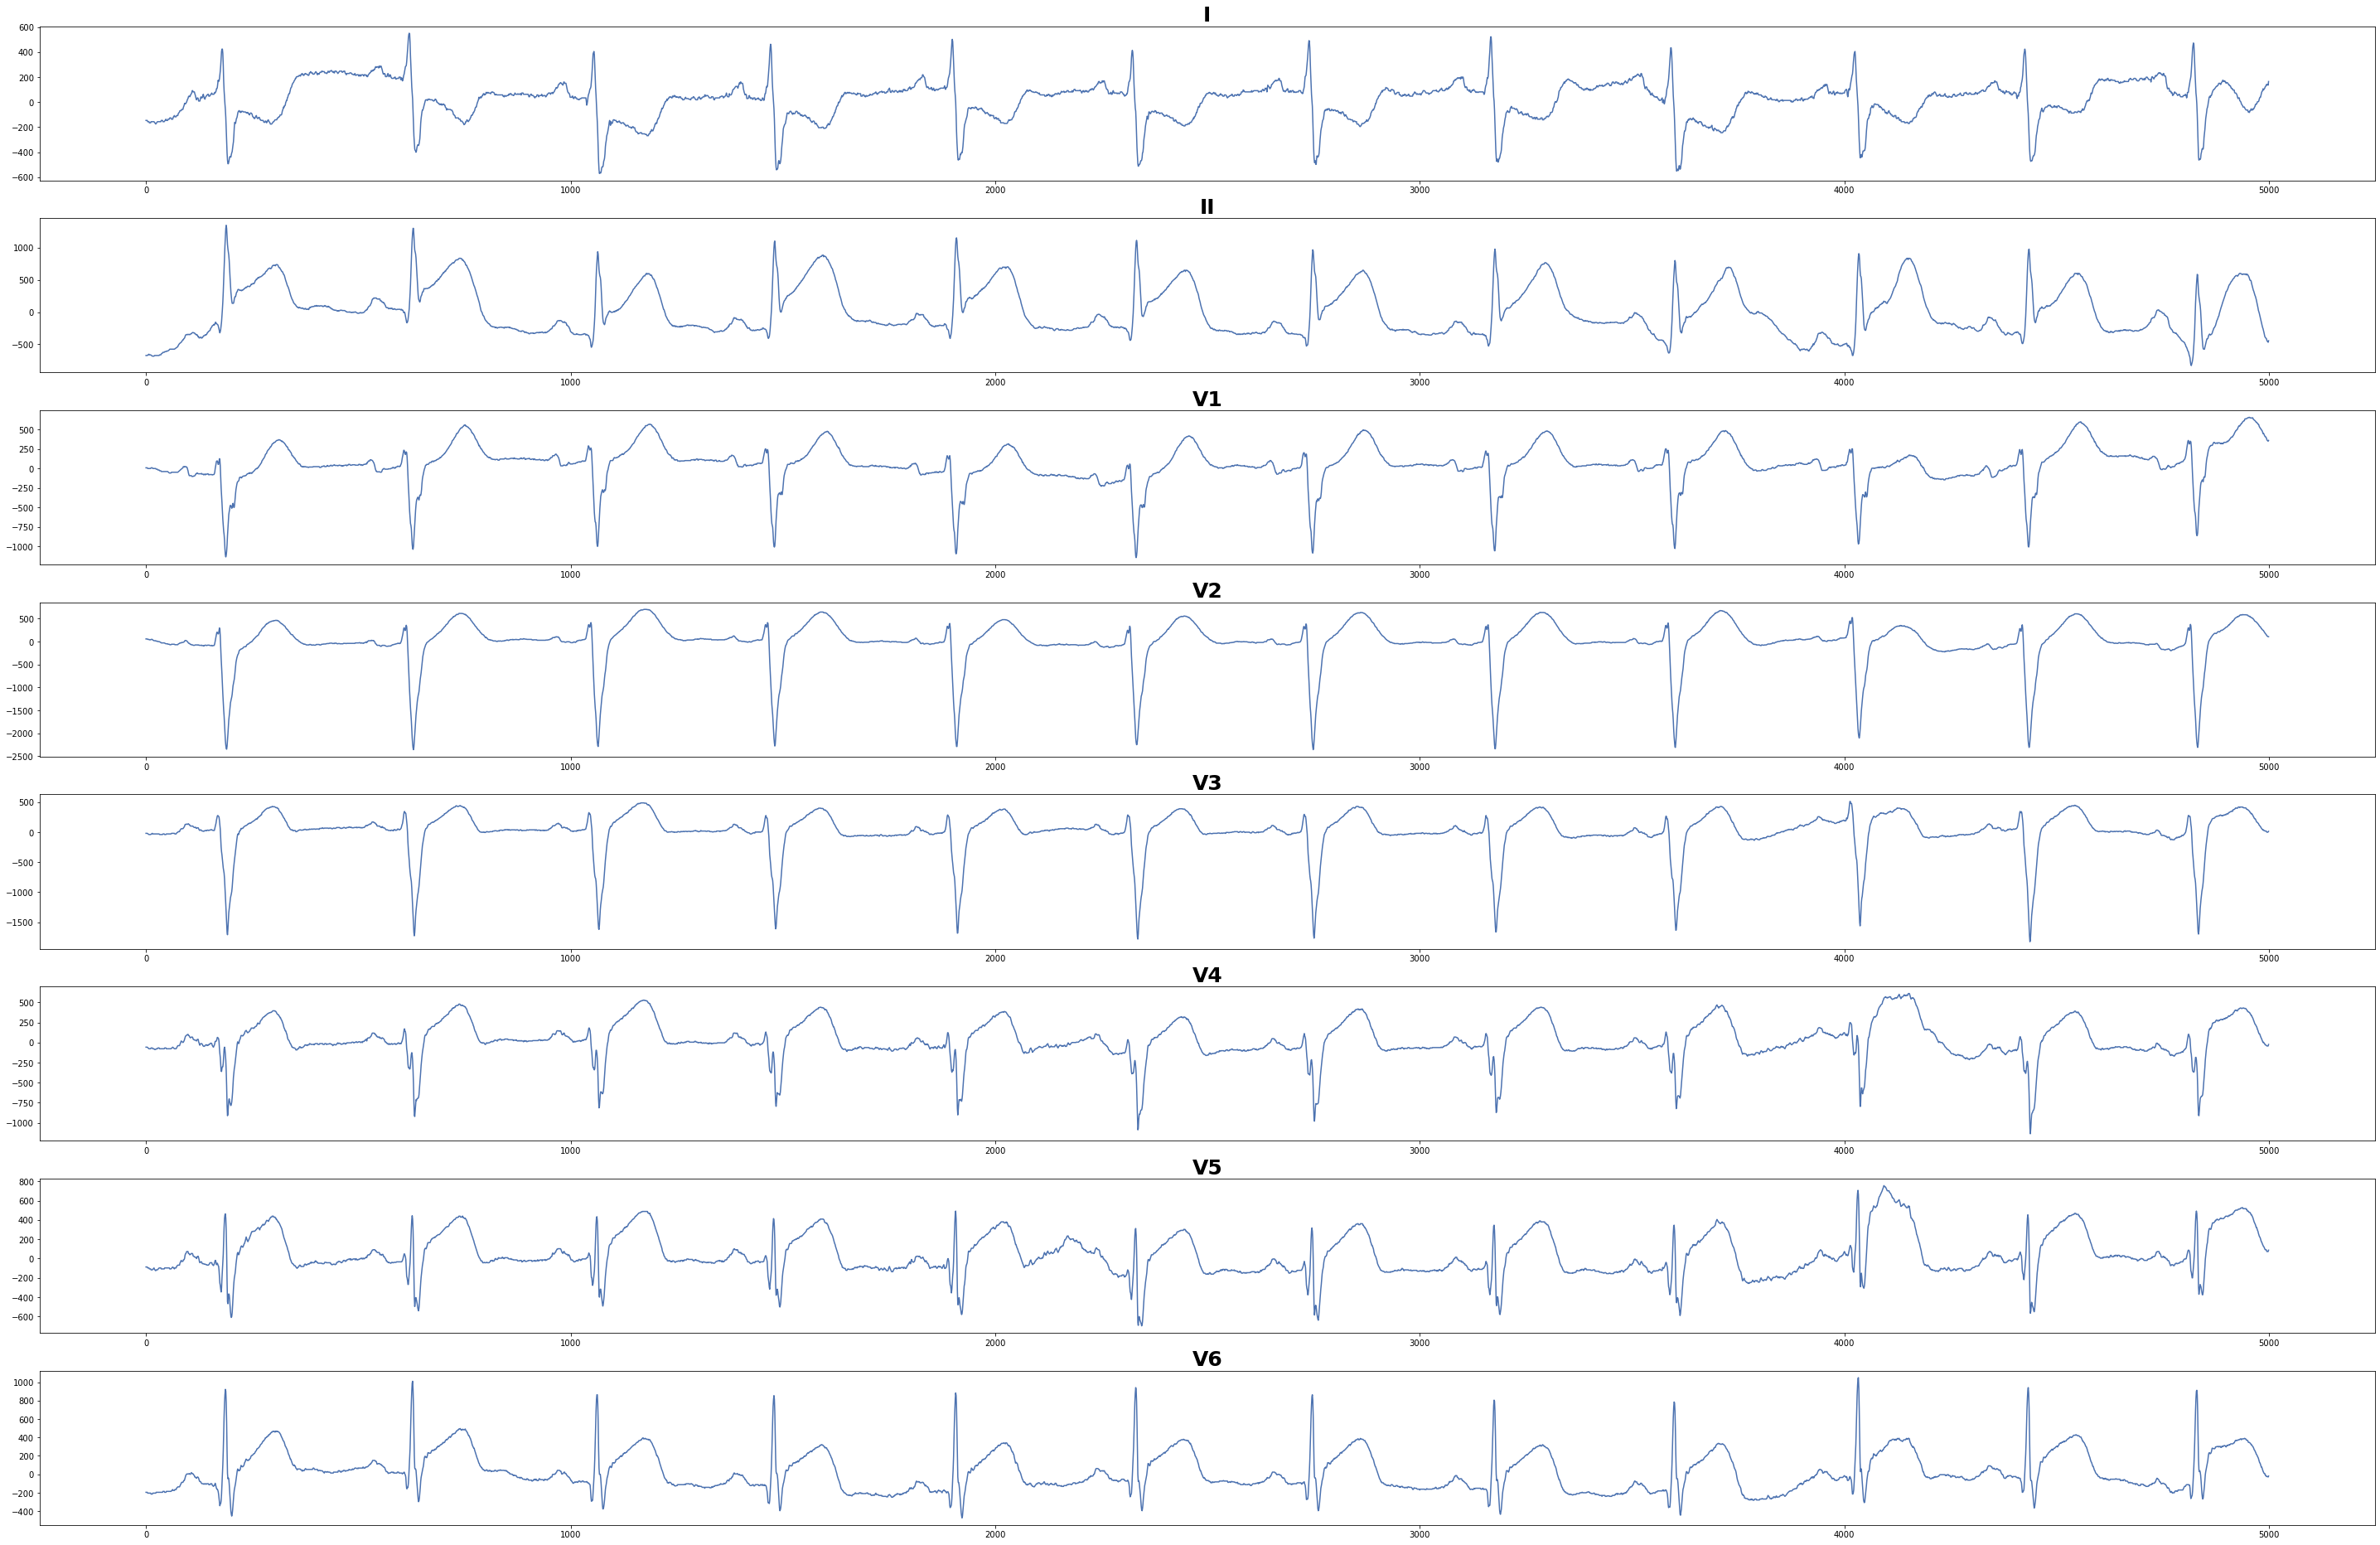

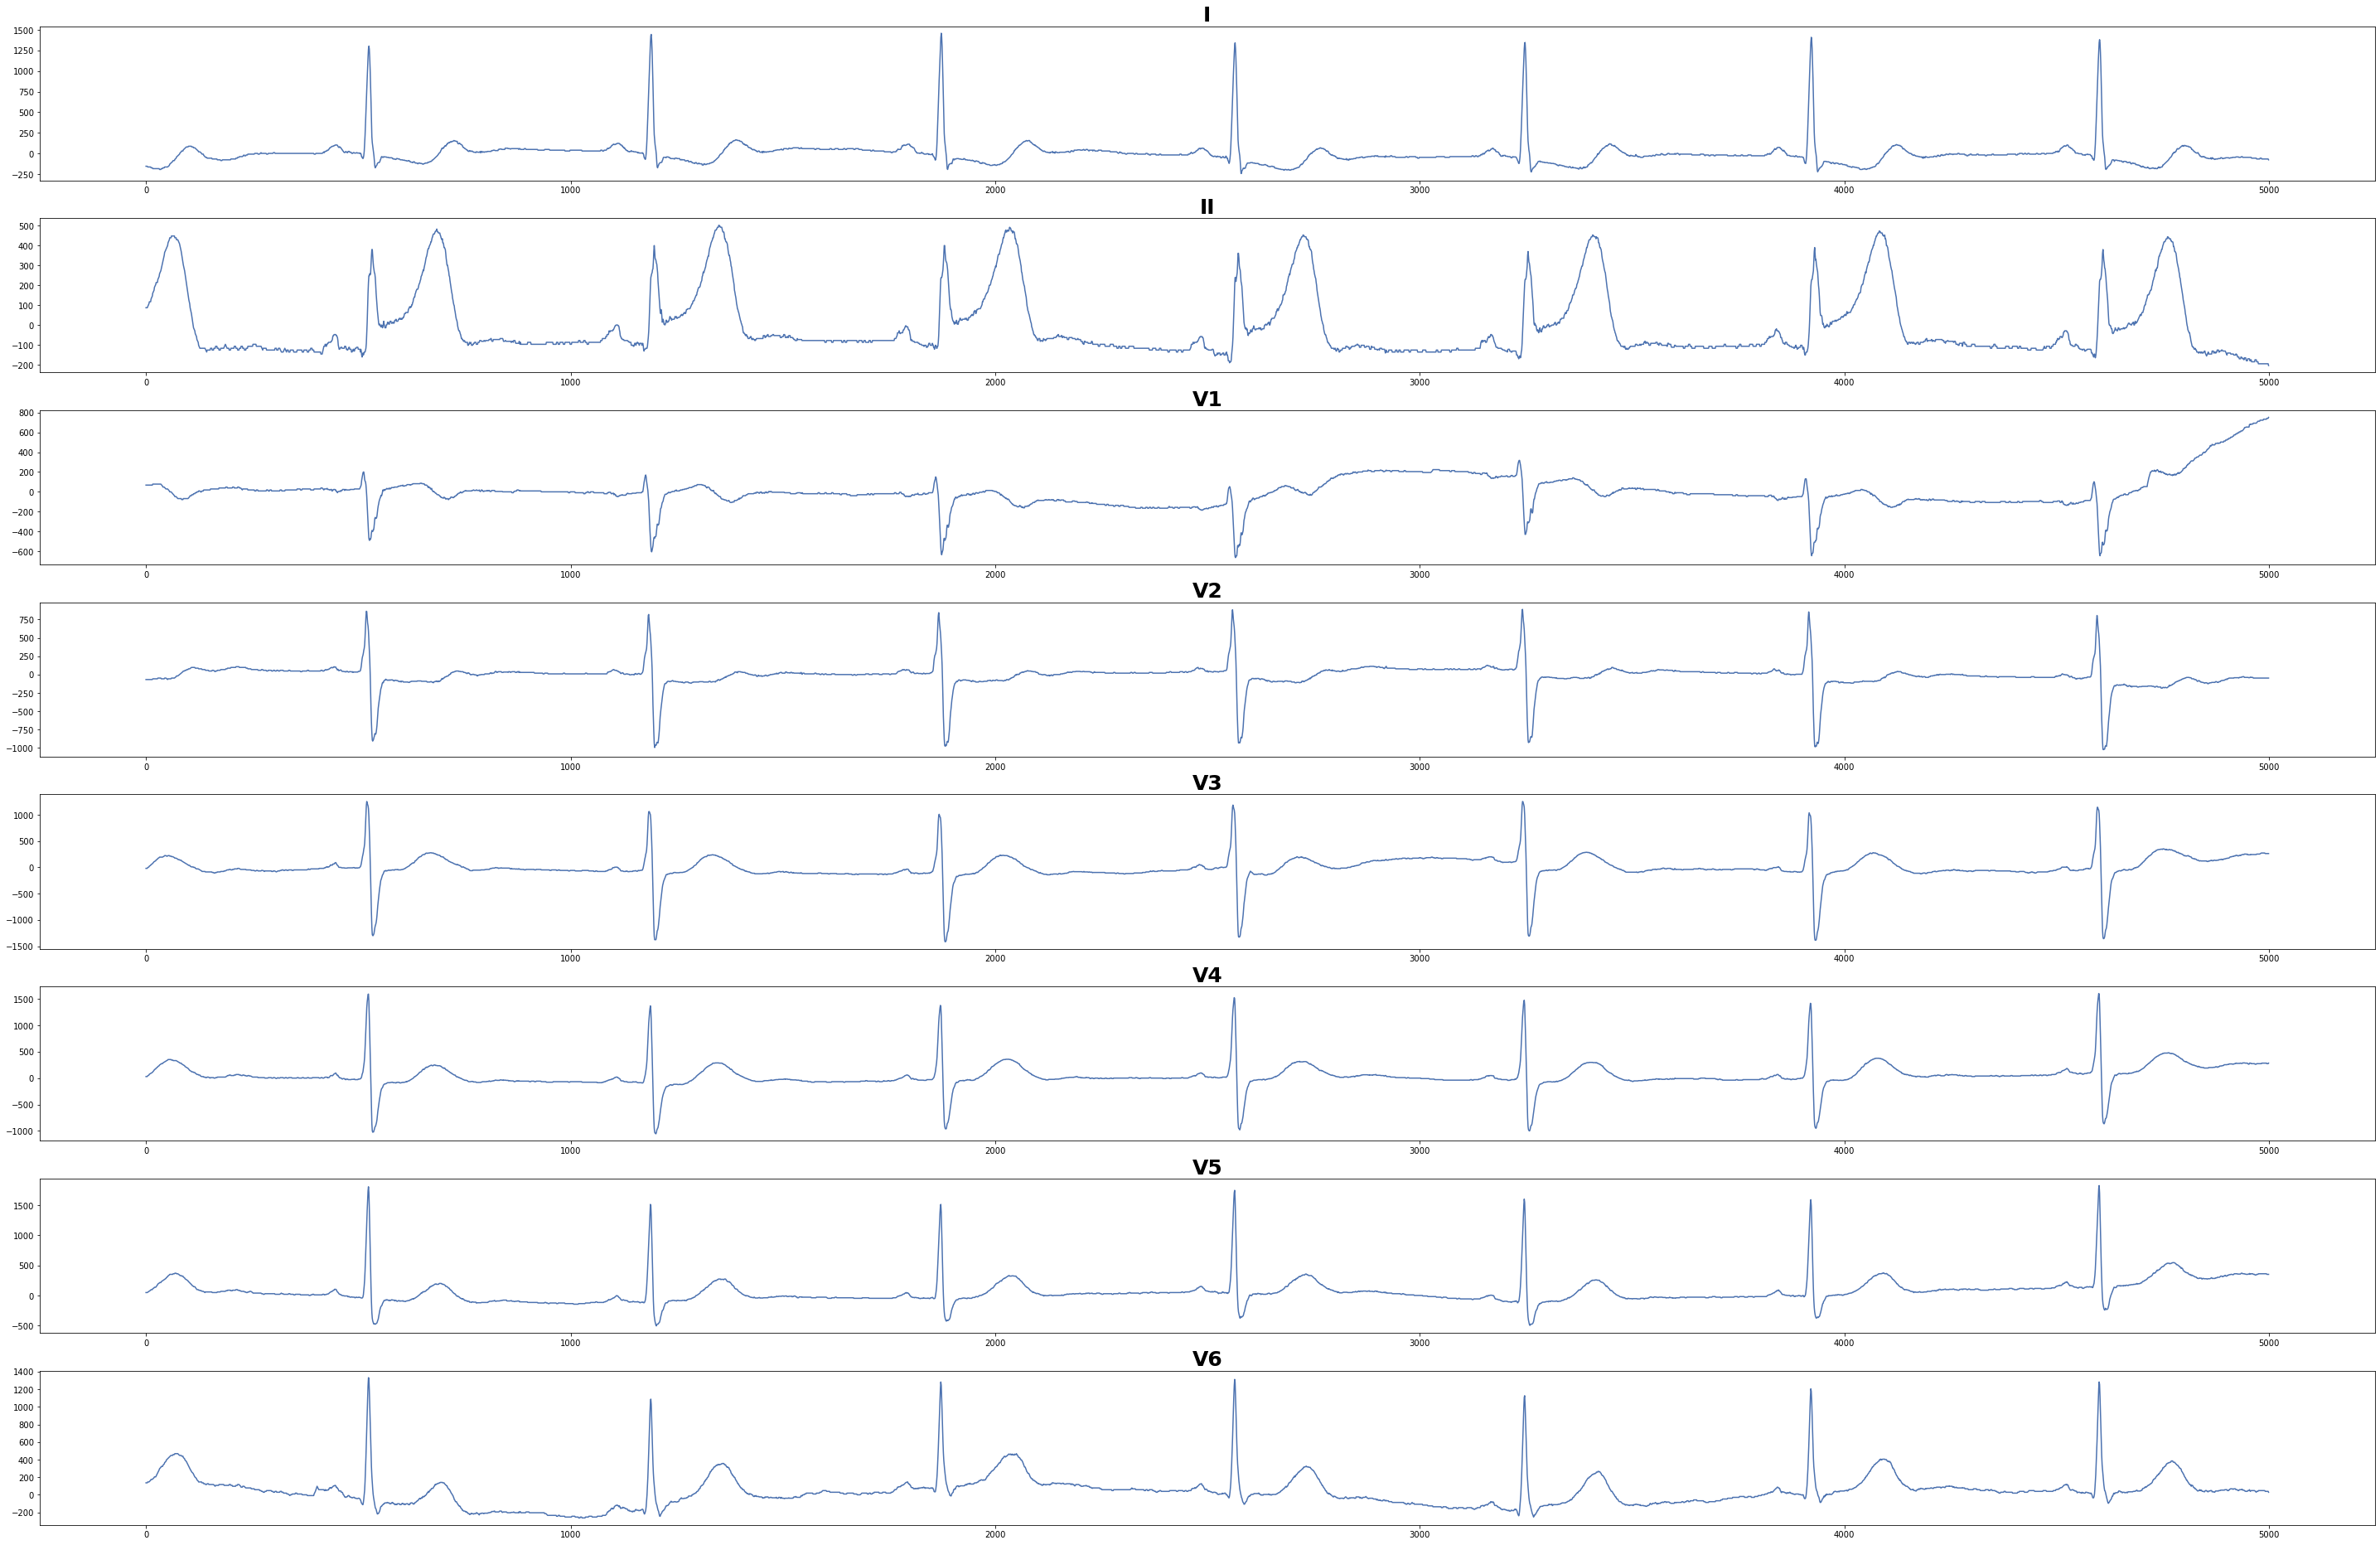

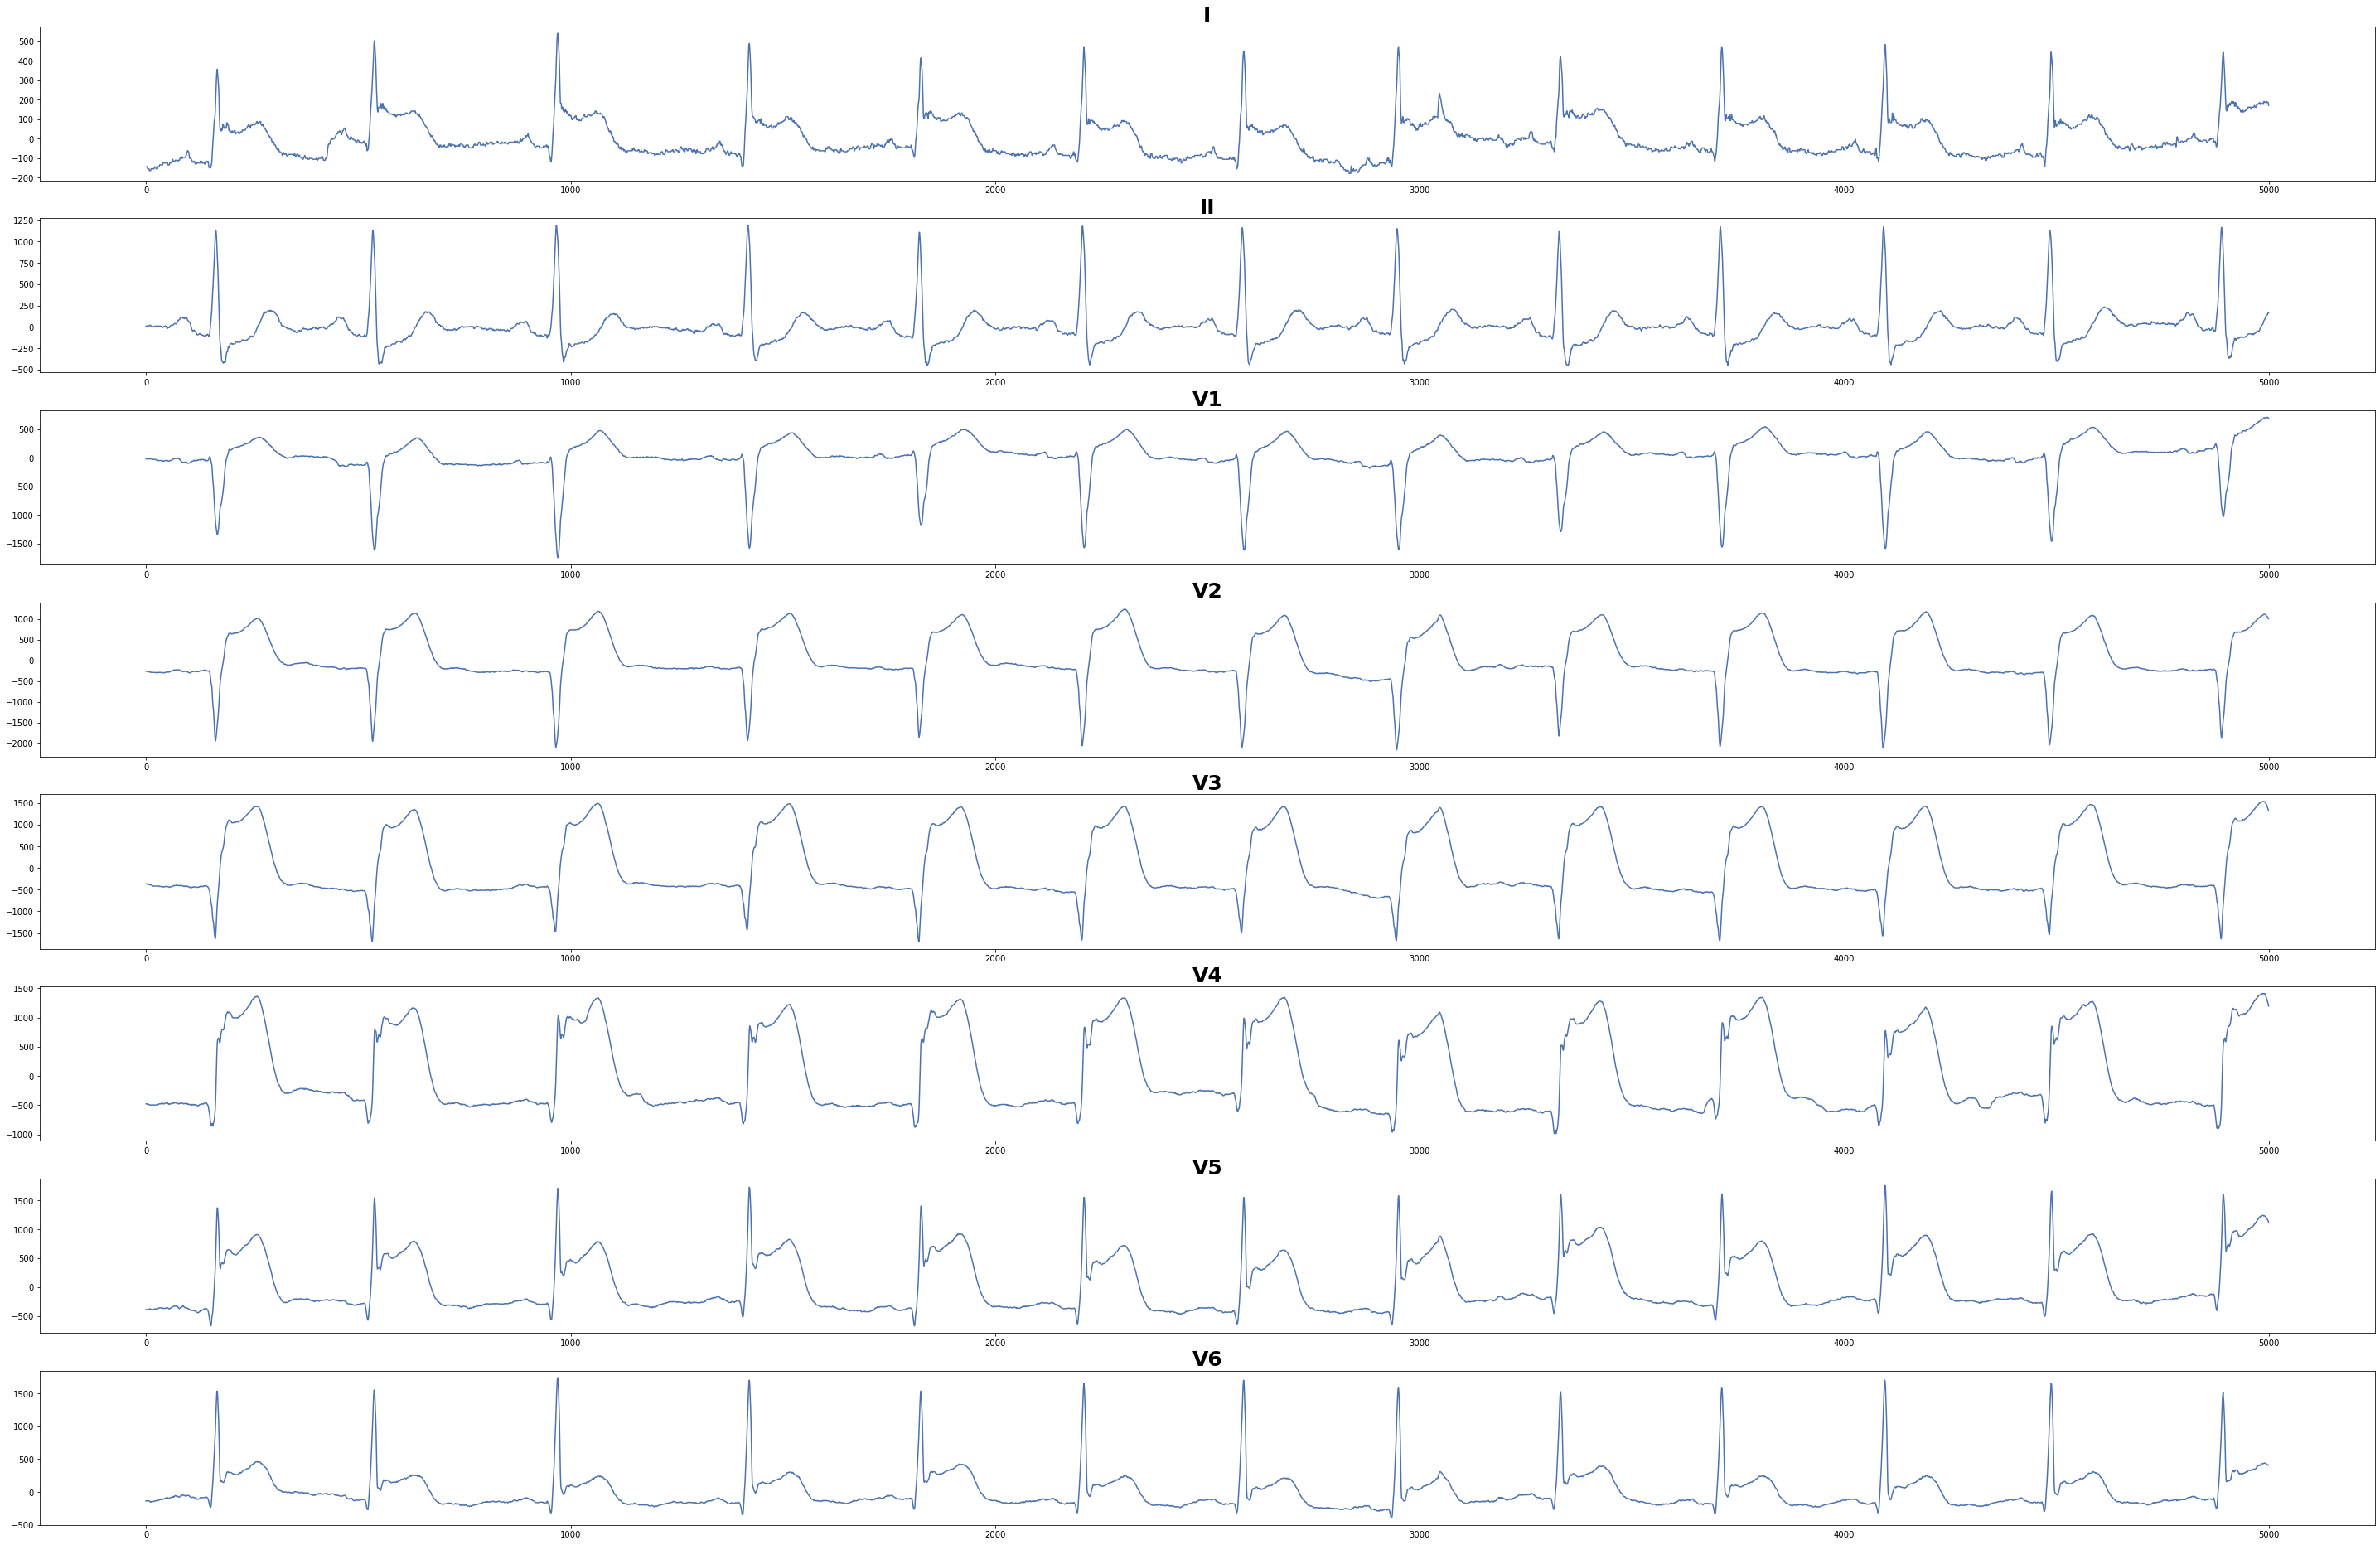

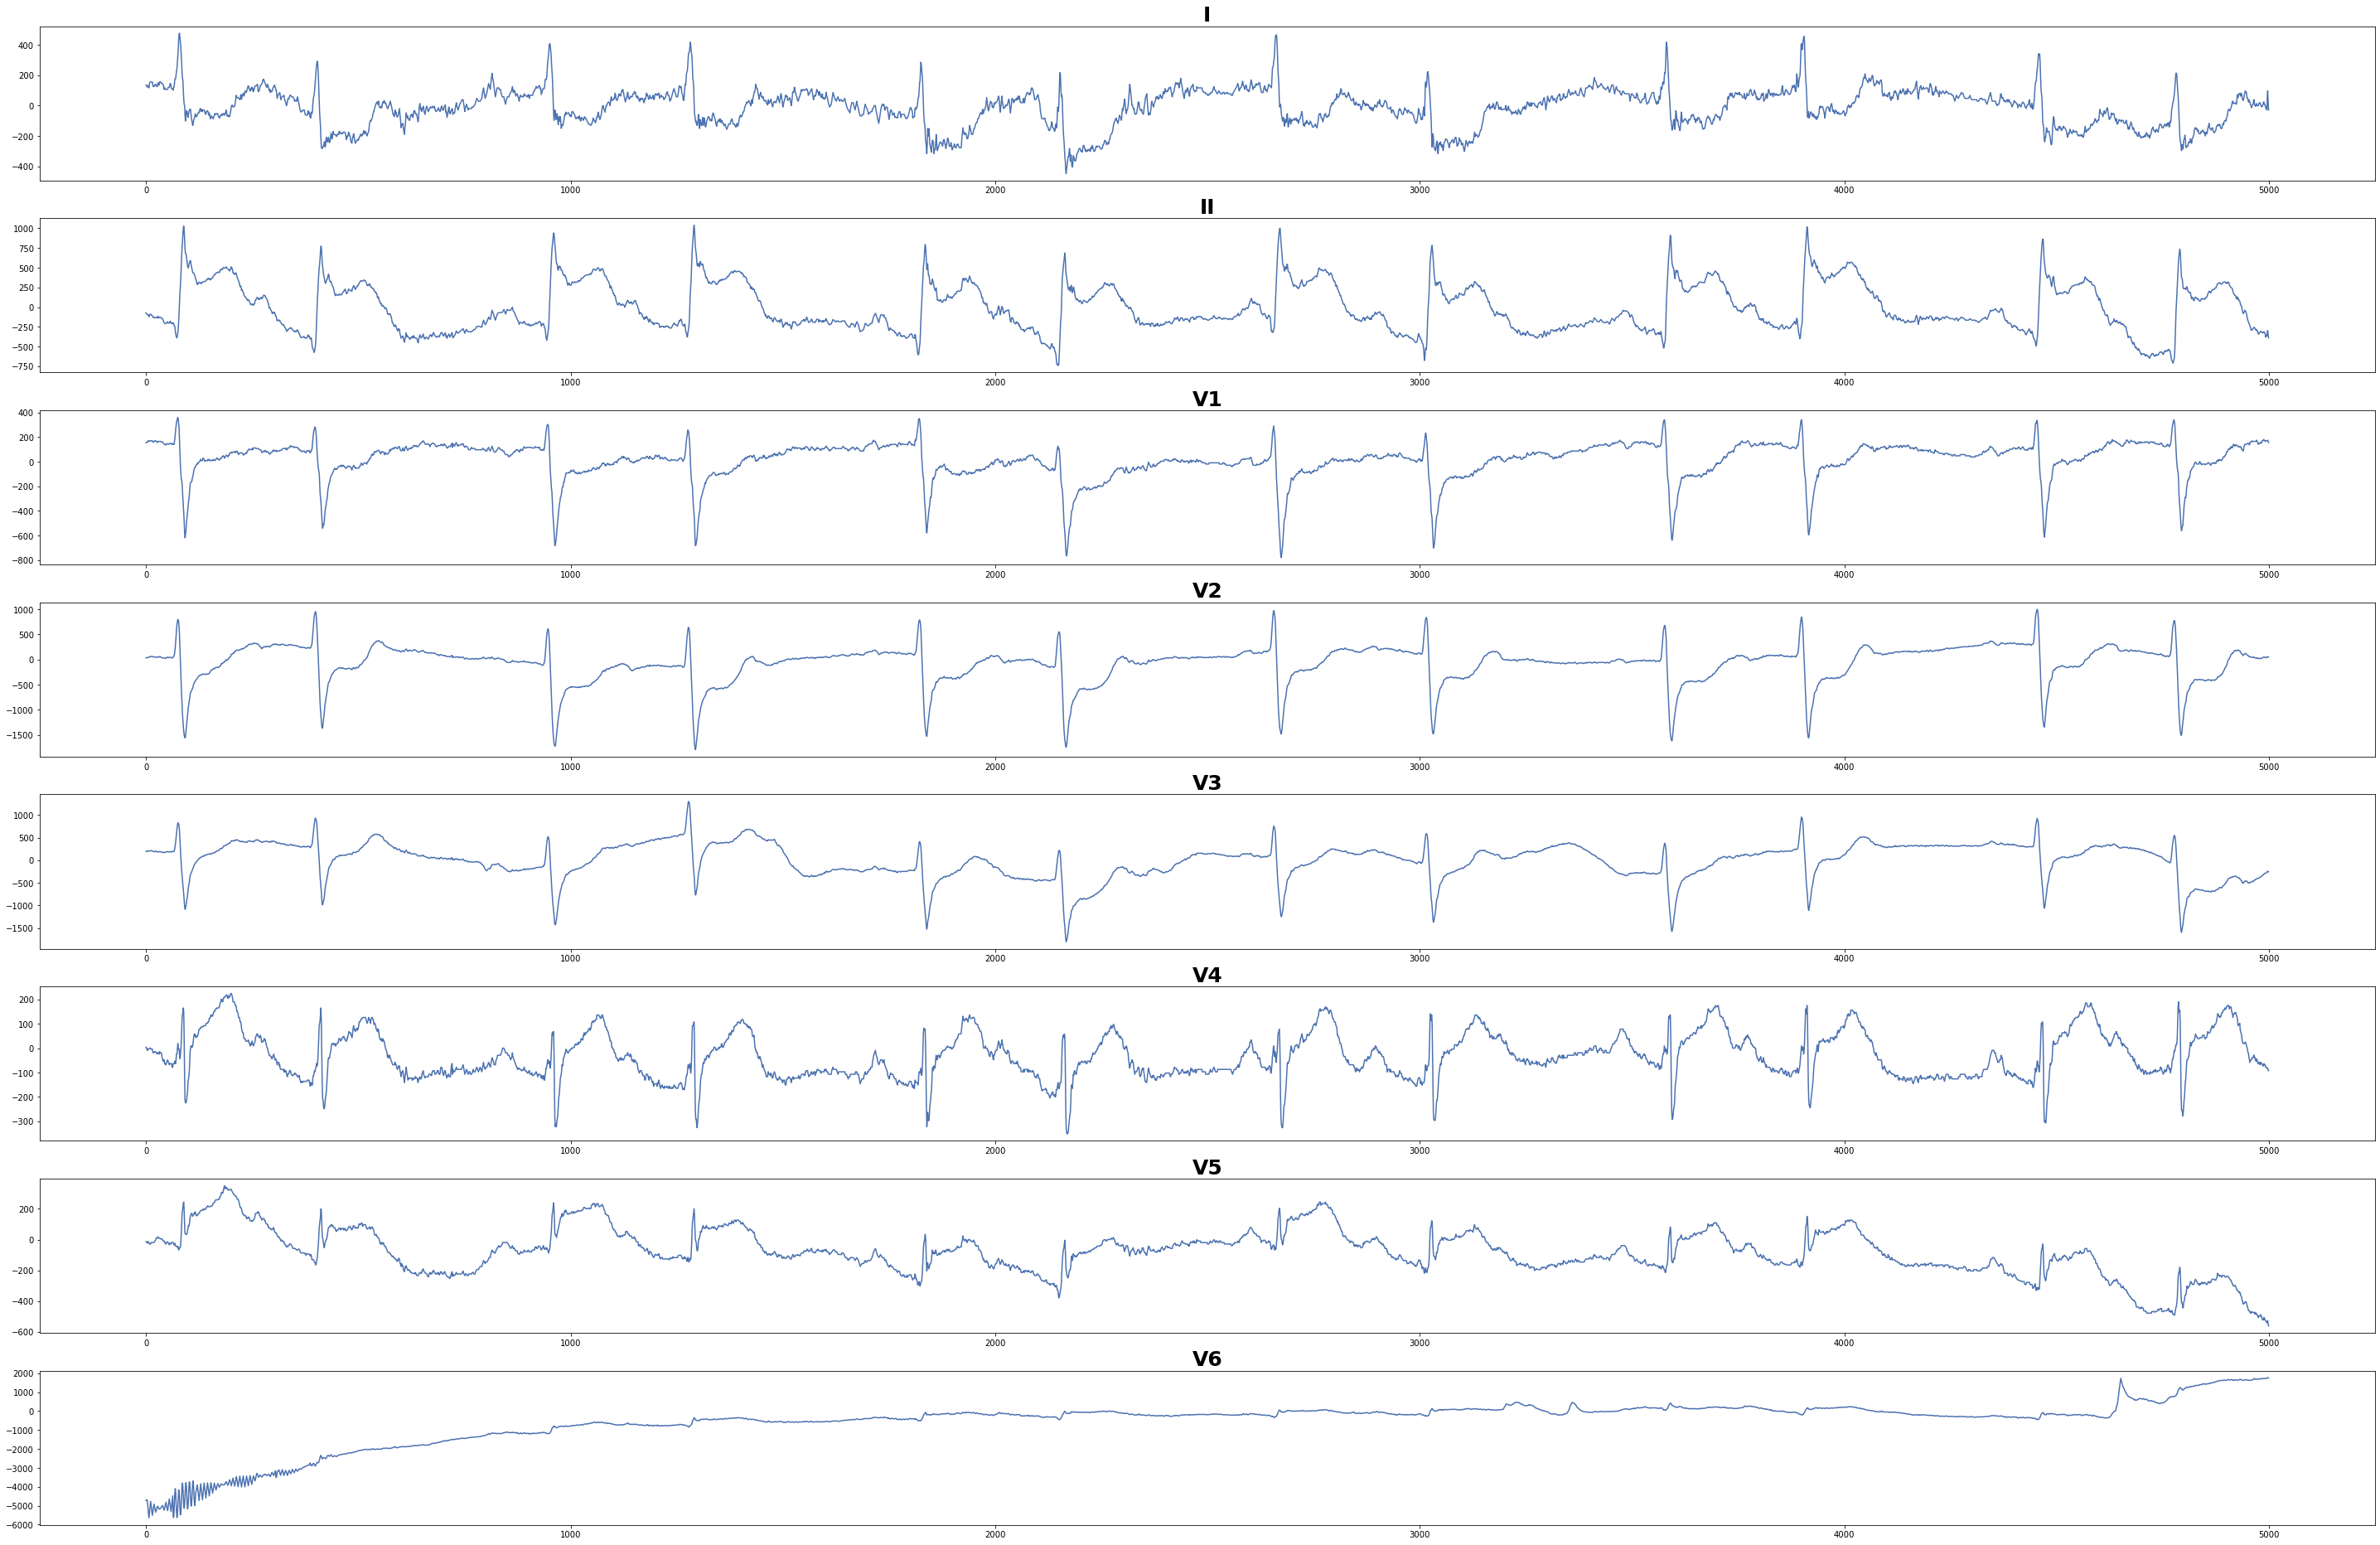

In [203]:
for i in stemi_props1:
    show_waveform(i)

81


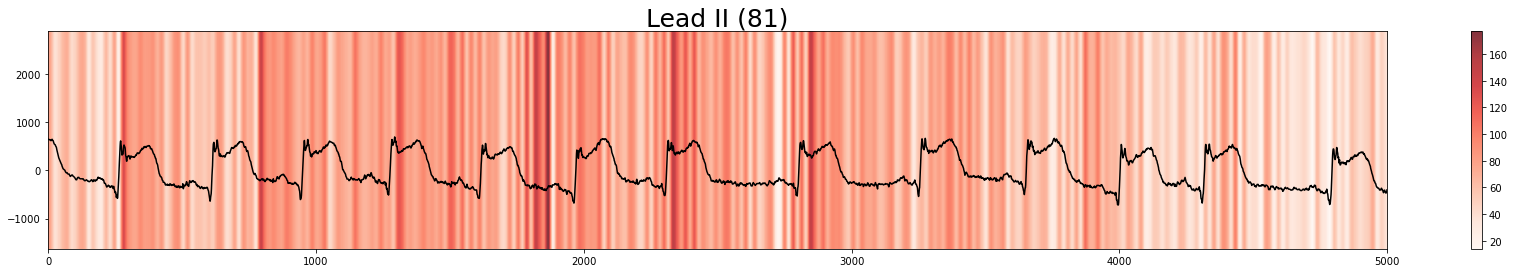

111


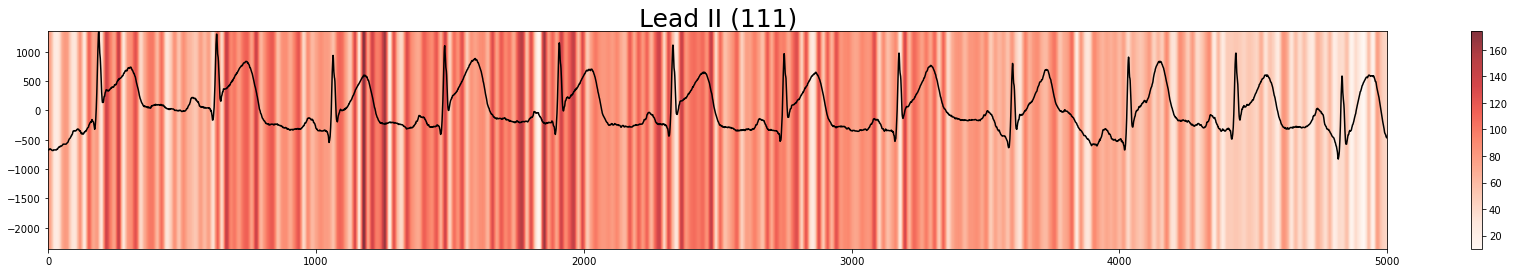

105


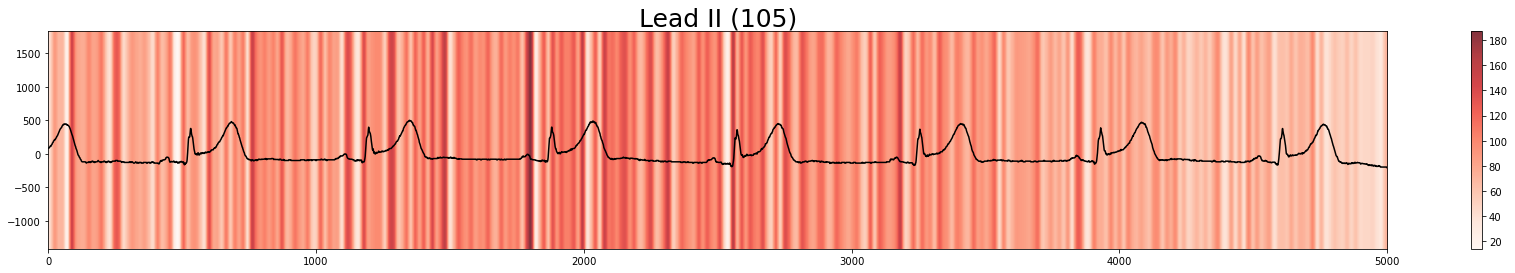

43


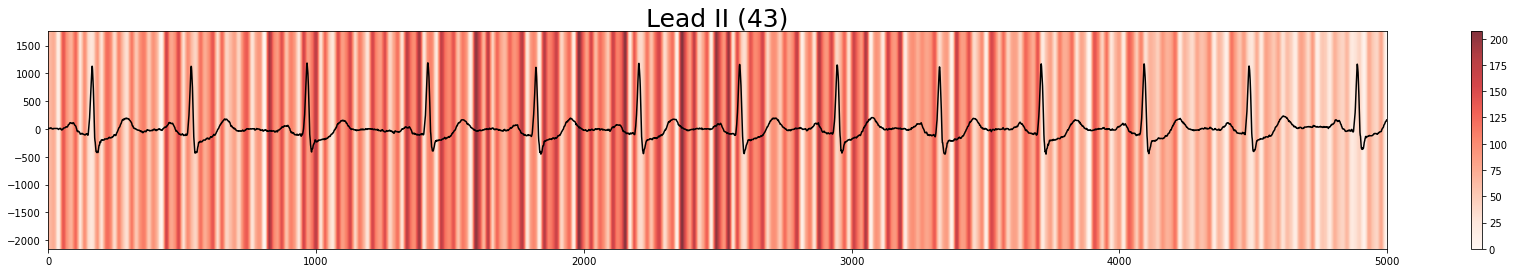

24


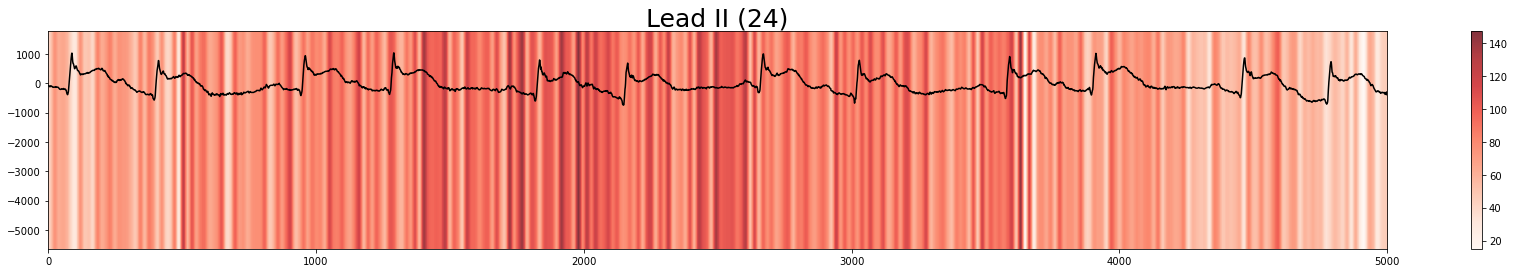

In [204]:
gcperls(stemi_props1, 1) #lead II